# <a href="#C1">E-commerce / Analyse des ventes d'une librairie

## Descriptif :
- Faire le point après 2 ans sur les résultats de la librairie en ligne pour ajuster la stratégie commerciale et marketing.

## Objectifs : 

#### I) Analyse des différents indicateurs de vente
- 1) Différents indicateurs et graphiques autour du chiffre d'affaires. 
- 2) L’évolution dans le temps
- 3) Mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale ?
- 4) Faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.
- 5) Quelques informations sur les profils de nos clients avec la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.
Après, toutes les informations et tous graphiques qui apporteraient de l’information pertinente sont les bienvenus !

#### II) Analyse plus ciblée sur les clients
- 1) le lien entre le genre d’un client et les catégories des livres achetés
- 2) le lien entre l’âge des clients et le montant total des achats
- 3) le lien entre l’âge des clients et la fréquence d’achat
- 4) le lien entre l’âge des clients et la taille du panier moyen
- 5) le lien entre l’âge des clients et les catégories des livres achetés.

# Collecter les données

In [105]:
# Import des modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
from scipy import stats
from scipy.stats import kendalltau, spearmanr
from scipy.stats import chi2_contingency
import scipy.stats as st
from scipy.stats import shapiro           # Test de Shapiro-Wilk
import pingouin as pg
import warnings

In [106]:
# Import des fichiers csv
products = pd.read_csv("products.csv")
customers = pd.read_csv("customers.csv")
transactions = pd.read_csv("transactions.csv")

# Nettoyer les données

In [107]:
# Création d'une fonction pour détecter les doublons
def check_doublons(df,id_):
    if df[id_].value_counts().max() == 1 : 
        print("La colonne " + id_ + " ne contient pas de doublons.")
    else:
        print(id_ + " contient des doublons, la liste des doublons est : ")
        temp = df[id_].value_counts().to_frame()
        display(temp[temp[id_] > 1])

# *** Fichier products ***

In [108]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [109]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


Pas de valeurs manquantes!

In [110]:
# Afficher le nombre de catégories
display(products["categ"].value_counts())

0    2309
1     739
2     239
Name: categ, dtype: int64

### *** Doublons ***

In [111]:
check_doublons(products,"id_prod")

La colonne id_prod ne contient pas de doublons.


### *** Valeurs aberrantes (Outliers) ***

In [112]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


Nous avons des prix négatifs (-1.00€)... or en France, il est interdit de vendre à pertes. Quels produits sont concernés par des prix négatifs ?

In [113]:
# Quel id_prod sont concernés par des prix négatifs ?
products[products["price"] <= -1]

,id_prod,price,categ
731,T_0,-1.0,0


La référence "T_0" est donc à supprimer du dataframe "products".

In [114]:
# Affiche le nombre de prix = -1
price_del = products[products["price"] <= -1].index
print("Il y a {:.0f} prix ≤ a -1€".format(price_del.shape[0]))
# Suppression des prix négatifs
products = products.drop(index=price_del)

Il y a 1 prix ≤ a -1€


### *** Distribution de la variable Price ***

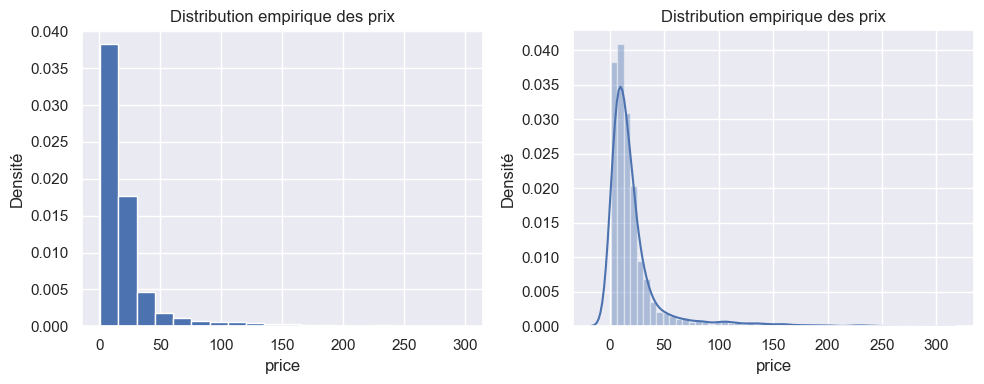

In [115]:
warnings.filterwarnings("ignore")
# Création de la grille d'affichage à 1 ligne et 2 colonnes
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Histogramme
products["price"].hist(density=True, bins=20, ax=axs[0])
axs[0].set_title("Distribution empirique des prix")
axs[0].set_xlabel("price")
axs[0].set_ylabel("Densité")

# Courbe de densité
sns.distplot(products["price"], ax=axs[1])
axs[1].set_title("Distribution empirique des prix")
axs[1].set_xlabel("price")
axs[1].set_ylabel("Densité")

# Ajuster l'espace entre les graphes
plt.tight_layout()
plt.show()

La variable "Price" ne suit pas une distribution Normale !

### *** Méthode arithmétique (z-score) ***

In [116]:
# Détecter les valeurs aberrantes en utilisant Z-score
s = []
def detecter_s(data):
    threshold = 3         # fixer la limite à 3 écarts types
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            s.append(i)
    return s

In [117]:
s_liste = detecter_s(products["price"])
print("Nous avons {:.0f} valeurs aberrantes dont le z_score est supérieur à 3 écarts-types.".format(len(s_liste)))

Nous avons 97 valeurs aberrantes dont le z_score est supérieur à 3 écarts-types.


### *** Liste des Outliers - Z-score ***

In [118]:
# Afficher les informations relatives aux valeurs aberrantes
outliers_z = products.loc[products["price"].isin(s_liste)]
outliers_z.sort_values("price").head()

,id_prod,price,categ
1464,2_60,111.72,2
2398,2_169,111.99,2
2155,2_73,111.99,2
241,2_231,111.99,2
2939,2_161,113.99,2


La technique du Z-score suppose que la variable "Price" suit une **distribution normale**, or nous avons démontré ci-dessus que cela n'était pas le cas et que les données étaient centrées à gauche. 

Par conséquent, nous allons utiliser une autre méthode appelée la méthode des moustaches de Tukey ou la méthode Tukey.

### *** Méthode arithmétique (Méthode Tukey) ***

In [119]:
# Sélection de la variable price
price_data = products["price"]

# Calculer l'intervalle interquartile (IQR)
Q1 = np.percentile(price_data, 25)
Q3 = np.percentile(price_data, 75)
IQR = Q3 - Q1

# Calculez les limites inférieures et supérieures
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifier les outliers
outliers = price_data[(price_data < lower_bound) | (price_data > upper_bound)]

# Afficher le seuil de prix
print("Le seuil de prix des outliers est > {:.2f}€".format(outliers.min()))

Le seuil de prix des outliers est > 46.99€


### *** Liste des Outliers - Tukey ***

In [120]:
# Création du dataframe outliers_Tukey
outliers_Tukey = products.loc[products["price"] > outliers.min(), :].sort_values("price")
display(outliers_Tukey.shape)
outliers_Tukey.head()

(300, 3)

,id_prod,price,categ
49,1_48,47.22,1
2966,1_620,47.30,1
3169,1_626,47.35,1
1507,1_254,47.69,1
954,1_664,47.83,1


In [121]:
# Combien de prix unique ?
outliers_Tukey["price"].nunique()

234

Résulats - Tukey :
- les valeurs supérieures ou égales à 46.99€ sont considérées comme étant des valeurs aberrantes. 
- Nous avons 234 prix atyiques et/ ou aberrants qui sont ≥ 46.99€.
- 300 produits sont impactés

### *** Méthode graphique ***


Text(0.5, 1.0, 'Distribution des Prix')

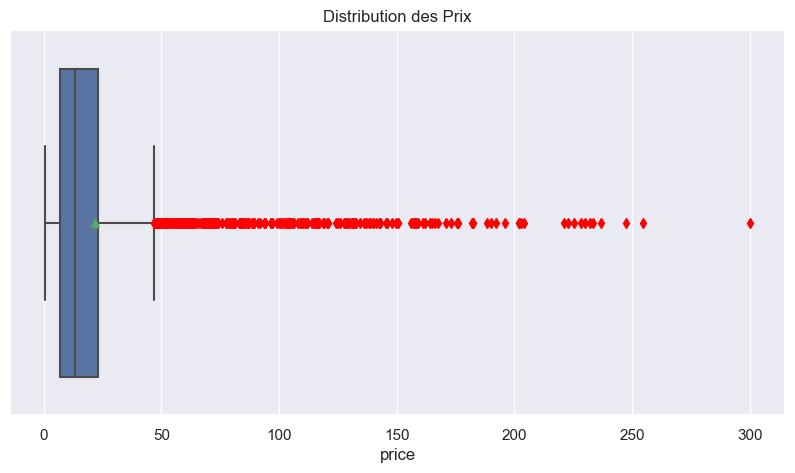

In [122]:
# Méthode graphique
boxplot = sns.boxplot(x="price", data=products, showmeans=True, flierprops={"markerfacecolor": "red", "markeredgecolor": "red"})
boxplot.set_title("Distribution des Prix")

Il faut demander à Antoine quel est le prix maximum appliqué de façon à connaitre la limite à prendre en compte et pouvoir traiter les outliers.

Hypothéses : 
- Nous avons 234 prix atypiques et/ ou aberrants qui sont  ≥  46.99€.

Nous allons les remplacer par la médiane des prix appliqués. Je ne souhaite pas les supprimer car les produits auxquels ils sont référencés ont peut-être généré des ventes et seront donc importants pour l'analyse.

In [123]:
# Création d'une colonne Outlier
products.loc[products.price >= 46.99, "outlier"] = 1
products.loc[products.price < 46.99, "outlier"] = 0
# Vérifions
products.loc[products["id_prod"].isin(outliers_Tukey["id_prod"]), :].head()

,id_prod,price,categ,outlier
10,2_228,225.17,2,1.0
11,1_178,51.92,1,1.0
38,2_100,72.11,2,1.0
49,1_48,47.22,1,1.0
64,2_89,107.99,2,1.0


Text(0.5, 1.0, '2) Distribution des prix par catégories')

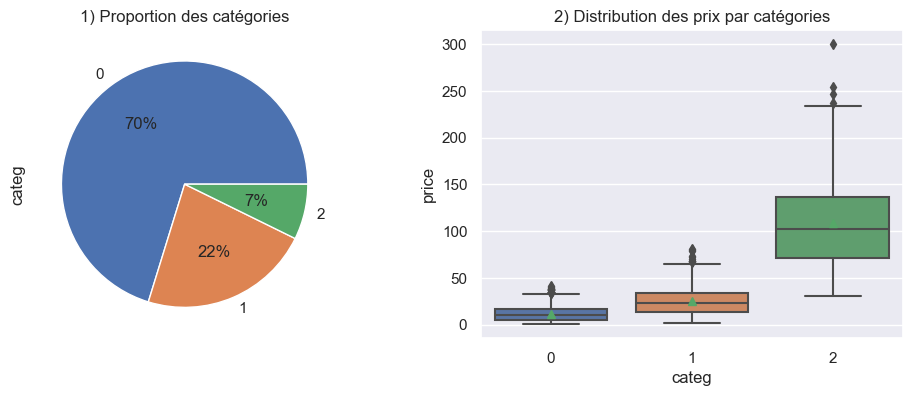

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# 1) Pie chart (ou camembert)
products["categ"].value_counts().plot(kind="pie", autopct="%1.0f%%", ax=axs[0])
axs[0].set_title("1) Proportion des catégories")
# 2) Boxplot (diagramme à moustaches)
sns.boxplot(data=products, x="categ", y="price", showmeans=True, ax=axs[1])
axs[1].set_title("2) Distribution des prix par catégories")

- La catégorie 0 représente 70% des achats mais en revanche les prix associés sont les plus bas.
- La catégorie 2 représente 7% des achats mais en revanche les prix associés sont ceux qui varient le plus dépassant les 200€ et ayant un prix médian ≈ 100€.

#
# *** Fichier customers ***

In [125]:
customers.sort_values("birth").head()

,client_id,sex,birth
4569,c_577,m,1929
2491,c_8362,f,1929
418,c_5302,m,1929
1086,c_3218,f,1930
5138,c_7232,f,1930


In [126]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


Pas de valeurs manquantes!

### *** Doublons ***

In [127]:
check_doublons(customers,"client_id")

La colonne client_id ne contient pas de doublons.


### *** Valeurs aberrantes (Outliers) ***

Les personnes nées avant 1932 ont plus de 90 ans, je doute qu'elles soient à l'origine des commandes en lignes. Cependant, cela n'est pas impossible et nous garderons ces valeurs **atypiques**.

Text(0.5, 1.0, "Distribution de l'âge de la clientèle")

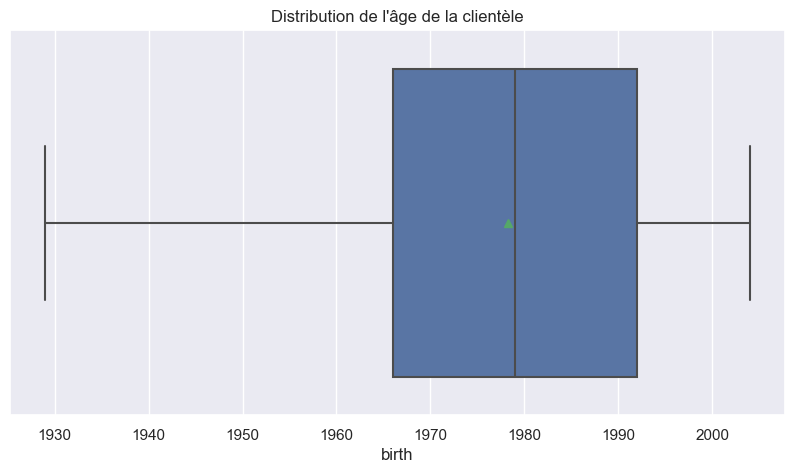

In [128]:
boxplot = sns.boxplot(x="birth", data=customers, showmeans=True, flierprops={"markerfacecolor": "red", "markeredgecolor": "red"})
boxplot.set_title("Distribution de l'âge de la clientèle")

On constate que le 1er quartile affiche une plus grande dispersion que Q2/Q3 et Q4. A noter que l'age moyen est proche de l'âge médian.

In [129]:
customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


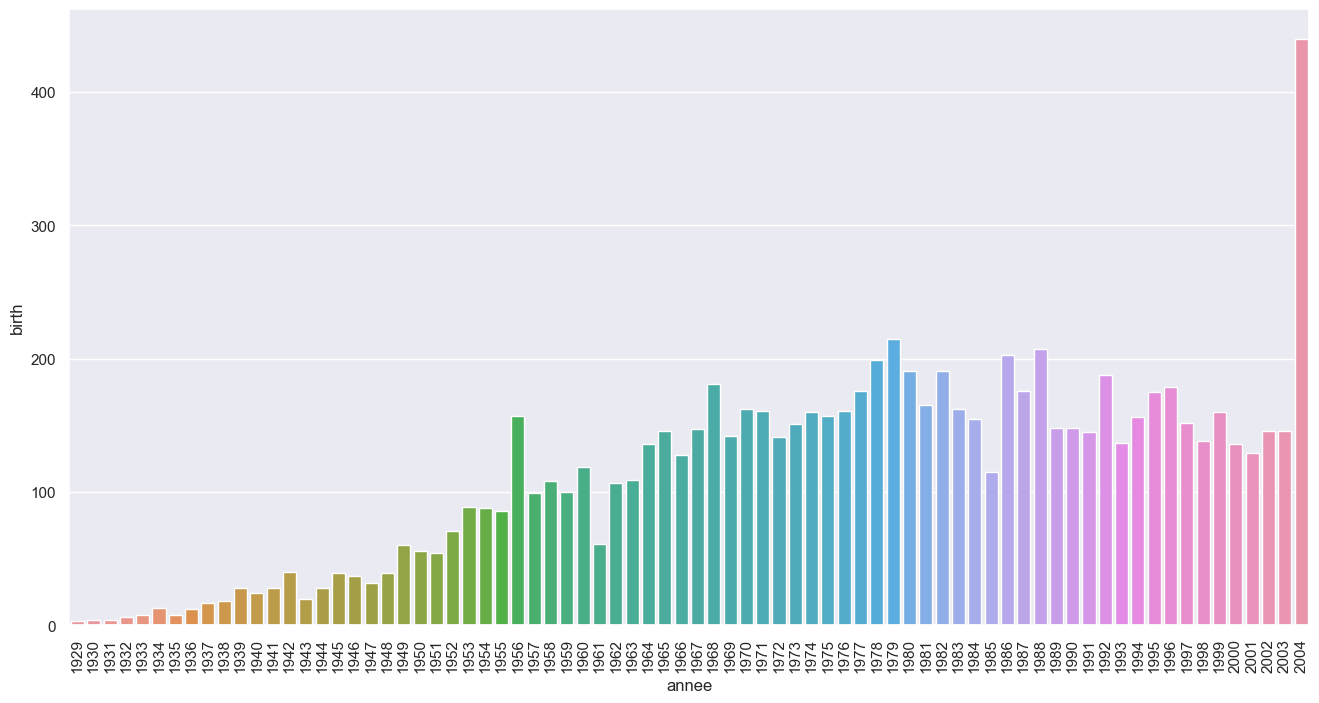

In [130]:
# Création du dataframe customers_birth
customers_birth = customers["birth"].value_counts().to_frame().sort_index().reset_index().rename(columns={"index":"annee"})
customers_birth["annee"] = customers_birth["annee"].astype(str)
# Histogramme
sns.set(rc={"figure.figsize":(16,8)})
sns.barplot(data=customers_birth, x="annee", y="birth")
plt.xticks(rotation=90)
plt.show()

On constate que l'année 2004 recence un nombre significativement plus élevée que les autres années. 

Hypothèse : le site internet requiert peut-être un age légal limite de 18 ans pour pouvoir s'inscrire.

Text(0.5, 1.0, '2) Proportion Homme/ Femme')

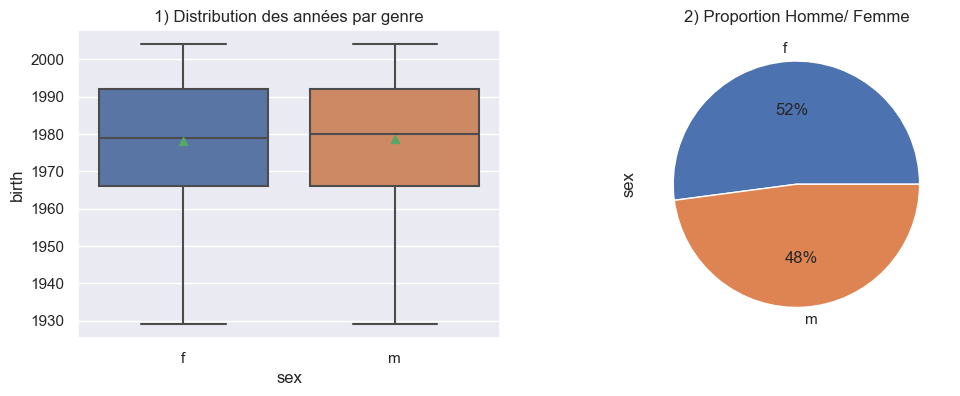

In [131]:
# 1) Boxplot (diagramme à moustaches)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=customers, x="sex", y="birth", showmeans=True, ax=axs[0])
axs[0].set_title("1) Distribution des années par genre")
# 2) Pie chart (ou camembert)
customers["sex"].value_counts().plot(kind="pie",autopct="%1.0f%%", ax=axs[1])
axs[1].set_title("2) Proportion Homme/ Femme")

1) On constate que la distribution des années en fonction du genre est similaire.
2) Les femmes représentent 52% des clients, on peut dire qu'il y a presque autant de femme que d'homme sur l'échantillon étudié.

#
# *** Fichier transactions ***

In [132]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [133]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


Pas de valeurs manquantes!

### *** Le produit T_0 est-il référencé dans le fichier transactions ? ***

In [134]:
transactions.loc[transactions["id_prod"] == "T_0", :]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [135]:
transactions.loc[transactions["date"].str.contains("test_")][["id_prod"]].value_counts()

id_prod
T_0        200
dtype: int64

T_0 est présent dans 200 session_id et on sait également que "test" est mentonné 200 fois. Nous avons donc la confirmation que tous les "tests" ont été identifié.

### *** Suppression du produit "T_0" ***

In [136]:
# Suppression des "test" lié à T_0
transactions = transactions[~transactions["id_prod"].str.contains("T_0")]

### *** Modification du type de la Variable date ***

Nous allons changer le data type de la colonne date actuellement en texte pour la passer en format date.
- aaaa-mm-dd hh:mm:ss.millisecondes

In [137]:
# Passage en date
transactions["date"] = pd.to_datetime(transactions["date"])

In [138]:
# Vérifions le data type de date
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 25.9+ MB


In [139]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


### *** Doublons ***

Si 1 client a acheté le même produit à la même date et que nous avons plus d'une ligne, il s'agit d'un doublon.

In [140]:
# Recherche de doublons du trio "id_prod", "client_id", "date"
transactions[transactions.duplicated(subset=["id_prod", "client_id", "date"])].head()

,id_prod,date,session_id,client_id


Pas de doublons.

Les données de nos 3 fichiers sources ont été néttoyé. Avant de commencer les jointures, il faut garder à l'esprit que le fichier "transactions" doit être perçu comme une table de liaison faisant le pont entre les deux autres fichiers "products" et "customers".

#
# *** Jointure des fichiers (transactions et products) ***

In [141]:
# Jointure entre transactions et products
transactions_products = pd.merge(transactions, products, how="outer", on="id_prod", indicator=True)
transactions_products.head()

,id_prod,date,session_id,client_id,price,categ,outlier,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,0.0,both
1,0_1518,2021-09-26 12:37:29.780414,s_95811,c_6197,4.18,0.0,0.0,both
2,0_1518,2021-05-06 17:14:43.117440,s_30782,c_682,4.18,0.0,0.0,both
3,0_1518,2022-03-16 18:57:10.420103,s_180057,c_5932,4.18,0.0,0.0,both
4,0_1518,2022-11-12 18:58:10.574853,s_296584,c_7217,4.18,0.0,0.0,both


In [142]:
transactions_products["_merge"].value_counts()

both          679111
left_only        221
right_only        21
Name: _merge, dtype: int64

On constate que la jointure s'est effectuée correctement sur 679111 valeurs mais nous devons analyser les valeurs left et right only.

In [143]:
# Regardons d'abord les right only
transactions_products[transactions_products["_merge"] == "right_only"].head()

,id_prod,date,session_id,client_id,price,categ,outlier,_merge
679332,0_1016,NaT,NaN,NaN,35.06,0.0,0.0,right_only
679333,0_1780,NaT,NaN,NaN,1.67,0.0,0.0,right_only
679334,0_1062,NaT,NaN,NaN,20.08,0.0,0.0,right_only
679335,0_1119,NaT,NaN,NaN,2.99,0.0,0.0,right_only
679336,0_1014,NaT,NaN,NaN,1.15,0.0,0.0,right_only


In [144]:
# Regardons d'abord les left only
transactions_products[transactions_products["_merge"] == "left_only"][["id_prod"]].value_counts()

id_prod
0_2245     221
dtype: int64

In [145]:
transactions_products[transactions_products["_merge"] != "left_only"]

,id_prod,date,session_id,client_id,price,categ,outlier,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,0.0,both
1,0_1518,2021-09-26 12:37:29.780414,s_95811,c_6197,4.18,0.0,0.0,both
2,0_1518,2021-05-06 17:14:43.117440,s_30782,c_682,4.18,0.0,0.0,both
3,0_1518,2022-03-16 18:57:10.420103,s_180057,c_5932,4.18,0.0,0.0,both
4,0_1518,2022-11-12 18:58:10.574853,s_296584,c_7217,4.18,0.0,0.0,both
...,...,...,...,...,...,...,...,...
679348,0_1624,NaT,NaN,NaN,24.50,0.0,0.0,right_only
679349,2_86,NaT,NaN,NaN,132.36,2.0,1.0,right_only
679350,0_299,NaT,NaN,NaN,22.99,0.0,0.0,right_only
679351,0_510,NaT,NaN,NaN,23.66,0.0,0.0,right_only


On sait que le fichier "transaction" est un fichier qui fait la liaison. Nous allons effectuer la dernière jointure avant de prendre une décision sur le traitement des ces valeurs.

#
# *** Jointure des fichiers (transactions_products et customers) ***

In [146]:
# Jointure entre transactions_products et customers
data = pd.merge(transactions_products.drop("_merge", axis=1), customers, how="outer", on="client_id", indicator=True)
data.head()

,id_prod,date,session_id,client_id,price,categ,outlier,sex,birth,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,0.0,f,1986.0,both
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0.0,0.0,f,1986.0,both
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,4.18,0.0,0.0,f,1986.0,both
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,8.57,0.0,0.0,f,1986.0,both
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,8.57,0.0,0.0,f,1986.0,both


In [147]:
data["_merge"].value_counts()

both          679332
right_only        23
left_only         21
Name: _merge, dtype: int64

In [148]:
# Regardons d'abord les left only
data[data["_merge"] == "left_only"].head()

,id_prod,date,session_id,client_id,price,categ,outlier,sex,birth,_merge
679332,0_1016,NaT,NaN,NaN,35.06,0.0,0.0,NaN,NaN,left_only
679333,0_1780,NaT,NaN,NaN,1.67,0.0,0.0,NaN,NaN,left_only
679334,0_1062,NaT,NaN,NaN,20.08,0.0,0.0,NaN,NaN,left_only
679335,0_1119,NaT,NaN,NaN,2.99,0.0,0.0,NaN,NaN,left_only
679336,0_1014,NaT,NaN,NaN,1.15,0.0,0.0,NaN,NaN,left_only


In [149]:
# Regardons d'abord les right only
data[data["_merge"] == "right_only"].head()

,id_prod,date,session_id,client_id,price,categ,outlier,sex,birth,_merge
679353,NaN,NaT,NaN,c_8253,NaN,NaN,NaN,f,2001.0,right_only
679354,NaN,NaT,NaN,c_3789,NaN,NaN,NaN,f,1997.0,right_only
679355,NaN,NaT,NaN,c_4406,NaN,NaN,NaN,f,1998.0,right_only
679356,NaN,NaT,NaN,ct_0,NaN,NaN,NaN,f,2001.0,right_only
679357,NaN,NaT,NaN,c_2706,NaN,NaN,NaN,f,1967.0,right_only


On constate que nous avons un total de 44 valeurs qui n'ont pas de correspondances. Nous ne pouvons rien en faire, étant maintenant identifiées. Nous allons les supprimer d'autant que session_id est vide pour les 44 valeurs ce qui indique qu'aucune transactions à été enregistrées.

In [150]:
# Suppression des NaN dans les colonnes id_prod et client_id
data = data.loc[~(data["id_prod"].isna()) & ~(data["client_id"].isna()), :]
data["_merge"].value_counts()

both          679332
left_only          0
right_only         0
Name: _merge, dtype: int64

### *** Valeurs manquantes (NaN) ***

In [151]:
data.isnull().sum()

id_prod         0
date            0
session_id      0
client_id       0
price         221
categ         221
outlier       221
sex             0
birth           0
_merge          0
dtype: int64

In [152]:
data[data["categ"].isna()]

,id_prod,date,session_id,client_id,price,categ,outlier,sex,birth,_merge
37861,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,NaN,NaN,NaN,f,1968.0,both
37862,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,NaN,NaN,NaN,f,1968.0,both
37863,0_2245,2022-04-05 17:04:43.982913,s_189669,c_6714,NaN,NaN,NaN,f,1968.0,both
37864,0_2245,2022-05-05 17:04:43.982913,s_204093,c_6714,NaN,NaN,NaN,f,1968.0,both
37865,0_2245,2022-12-05 17:04:43.982913,s_307520,c_6714,NaN,NaN,NaN,f,1968.0,both
...,...,...,...,...,...,...,...,...,...,...
654934,0_2245,2021-09-07 20:55:19.719028,s_86505,c_8153,NaN,NaN,NaN,f,1975.0,both
656406,0_2245,2021-10-20 13:11:05.671456,s_107564,c_1746,NaN,NaN,NaN,m,1994.0,both
660365,0_2245,2021-04-10 06:15:32.619826,s_18510,c_277,NaN,NaN,NaN,f,2000.0,both
660366,0_2245,2022-04-10 06:15:32.619826,s_191872,c_277,NaN,NaN,NaN,f,2000.0,both


In [153]:
data[data["price"].isna()]

,id_prod,date,session_id,client_id,price,categ,outlier,sex,birth,_merge
37861,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,NaN,NaN,NaN,f,1968.0,both
37862,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,NaN,NaN,NaN,f,1968.0,both
37863,0_2245,2022-04-05 17:04:43.982913,s_189669,c_6714,NaN,NaN,NaN,f,1968.0,both
37864,0_2245,2022-05-05 17:04:43.982913,s_204093,c_6714,NaN,NaN,NaN,f,1968.0,both
37865,0_2245,2022-12-05 17:04:43.982913,s_307520,c_6714,NaN,NaN,NaN,f,1968.0,both
...,...,...,...,...,...,...,...,...,...,...
654934,0_2245,2021-09-07 20:55:19.719028,s_86505,c_8153,NaN,NaN,NaN,f,1975.0,both
656406,0_2245,2021-10-20 13:11:05.671456,s_107564,c_1746,NaN,NaN,NaN,m,1994.0,both
660365,0_2245,2021-04-10 06:15:32.619826,s_18510,c_277,NaN,NaN,NaN,f,2000.0,both
660366,0_2245,2022-04-10 06:15:32.619826,s_191872,c_277,NaN,NaN,NaN,f,2000.0,both


On constate qu'il s'agit en réalité des même lignes pour les 2 colonnes price et categ. La colonne session_id étant remplies, il y a donc eu des **transactions**!

Nous avons donc ici un **problème MAJEUR, une ANOMALIE**! 

En effet, des ventes ont été faites mais les prix sont manquants car les produits impactés ne sont pas repertoriés dans le fichier "products". Nous pouvons toutes fois retrouver le numéro de catégories grâce à id_prod. 

In [154]:
data[data["categ"].isna()].head()

,id_prod,date,session_id,client_id,price,categ,outlier,sex,birth,_merge
37861,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,NaN,NaN,NaN,f,1968.0,both
37862,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,NaN,NaN,NaN,f,1968.0,both
37863,0_2245,2022-04-05 17:04:43.982913,s_189669,c_6714,NaN,NaN,NaN,f,1968.0,both
37864,0_2245,2022-05-05 17:04:43.982913,s_204093,c_6714,NaN,NaN,NaN,f,1968.0,both
37865,0_2245,2022-12-05 17:04:43.982913,s_307520,c_6714,NaN,NaN,NaN,f,1968.0,both


- Les 221 manquants de la colonne categ correspondent à 1 seul produit : 0_2245
- Remplacer les prix manquants par la médiane de la categ 0.

In [155]:
# Remplissage des NaN de la colonne categ par 0.0
data["categ"].fillna(0.0, inplace=True)
# Remplacer par la médiane les prix manquants
med_prix = data.loc[data["categ"] == 0, "price"].median()
data["price"].fillna(med_prix, inplace=True)
data.isnull().sum()

id_prod         0
date            0
session_id      0
client_id       0
price           0
categ           0
outlier       221
sex             0
birth           0
_merge          0
dtype: int64

In [156]:
data.loc[data["id_prod"] == "0_2245", :]

,id_prod,date,session_id,client_id,price,categ,outlier,sex,birth,_merge
37861,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,9.99,0.0,NaN,f,1968.0,both
37862,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,9.99,0.0,NaN,f,1968.0,both
37863,0_2245,2022-04-05 17:04:43.982913,s_189669,c_6714,9.99,0.0,NaN,f,1968.0,both
37864,0_2245,2022-05-05 17:04:43.982913,s_204093,c_6714,9.99,0.0,NaN,f,1968.0,both
37865,0_2245,2022-12-05 17:04:43.982913,s_307520,c_6714,9.99,0.0,NaN,f,1968.0,both
...,...,...,...,...,...,...,...,...,...,...
654934,0_2245,2021-09-07 20:55:19.719028,s_86505,c_8153,9.99,0.0,NaN,f,1975.0,both
656406,0_2245,2021-10-20 13:11:05.671456,s_107564,c_1746,9.99,0.0,NaN,m,1994.0,both
660365,0_2245,2021-04-10 06:15:32.619826,s_18510,c_277,9.99,0.0,NaN,f,2000.0,both
660366,0_2245,2022-04-10 06:15:32.619826,s_191872,c_277,9.99,0.0,NaN,f,2000.0,both


#
# *** Type des données ***

In [157]:
data.head()

,id_prod,date,session_id,client_id,price,categ,outlier,sex,birth,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,0.0,f,1986.0,both
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0.0,0.0,f,1986.0,both
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,4.18,0.0,0.0,f,1986.0,both
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,8.57,0.0,0.0,f,1986.0,both
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,8.57,0.0,0.0,f,1986.0,both


In [158]:
data.groupby("categ").agg("nunique")

,id_prod,date,session_id,client_id,price,outlier,sex,birth,_merge
categ,,,,,,,,,
0.0,2293,415680,225500,7896,954,1,2,76,1
1.0,737,227169,179216,8453,417,2,2,76,1
2.0,236,36483,30574,3597,197,2,2,76,1


In [159]:
# le paramétre ordered est défini sur False pour indiquer que les catégories ne sont pas ordonnées
data["categ"] = pd.Categorical(data["categ"], categories=[0, 1, 2], ordered=False)
data["sex"] = pd.Categorical(data["sex"], categories=["m", "f"], ordered=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   price       679332 non-null  float64       
 5   categ       679332 non-null  category      
 6   outlier     679111 non-null  float64       
 7   sex         679332 non-null  category      
 8   birth       679332 non-null  float64       
 9   _merge      679332 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(3), object(3)
memory usage: 43.4+ MB


#
# *** Analyse ***

Pour les analyses, nous allons ajouter à notre dataframe **data** les colonnes ci_dessous :
- mois, mois_texte, annee, trimestres
- age et tranche_age (2 versions)

In [160]:
# Créer une nouvelle colonne "mois" contenant le mois de chaque date
data["mois"] = data["date"].dt.month
data["mois_texte"] = data["date"].dt.strftime("%B")
# Créer une nouvelle colonne "année" contenant l'année de chaque date
data["annee"] = data["date"].dt.year.astype(str)
# Créer une nouvelle colonne "trim" contenant le trimestre de chaque date
data["trim"] = data["date"].dt.quarter
# Créer une nouvelle colonne "Age" contenant l'âge des clients
data["age_client"] = 2023 - data["birth"]

# Création de la colonne 'age_range1'
bins = [0, 20, 35, 62, float("inf")]    # float("inf") est utilisé pour créer une limite supérieure infinie
labels = ["< 20 ans", "20-35 ans", "35-62", "> 62 ans"]
data["tranche_age_client"] = pd.cut(data["age_client"], bins=bins, labels=labels)
# Création de la colonne 'age_range2'
bins2 = [0, 35, 62, float("inf")]    # float("inf") est utilisé pour créer une limite supérieure infinie
labels2 = ["< 35 ans", "35-62 ans", "> 62 ans"]
data["tranche_age_client2"] = pd.cut(data["age_client"], bins=bins2, labels=labels2)

# Suppression de la colonne _merge, outlier
data.drop(["_merge", "outlier"], axis=1, inplace=True)
# Affichage du dataframe data
data.sort_values("price").head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,mois,mois_texte,annee,trim,age_client,tranche_age_client,tranche_age_client2
638727,0_528,2021-10-20 05:44:08.973803,s_107417,c_5606,0.62,0,f,1959.0,10,October,2021,4,64.0,> 62 ans,> 62 ans
523027,0_202,2021-08-02 23:27:31.721723,s_70595,c_1367,0.62,0,f,1984.0,8,August,2021,3,39.0,35-62,35-62 ans
235392,0_202,2022-01-06 18:57:12.656309,s_145956,c_2069,0.62,0,m,1986.0,1,January,2022,1,37.0,35-62,35-62 ans
402924,0_528,2021-06-20 20:31:40.948364,s_51439,c_7075,0.62,0,m,1988.0,6,June,2021,2,35.0,20-35 ans,< 35 ans
246337,0_202,2022-01-27 19:25:10.843760,s_156085,c_7453,0.62,0,m,1986.0,1,January,2022,1,37.0,35-62,35-62 ans


In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id_prod              679332 non-null  object        
 1   date                 679332 non-null  datetime64[ns]
 2   session_id           679332 non-null  object        
 3   client_id            679332 non-null  object        
 4   price                679332 non-null  float64       
 5   categ                679332 non-null  category      
 6   sex                  679332 non-null  category      
 7   birth                679332 non-null  float64       
 8   mois                 679332 non-null  int64         
 9   mois_texte           679332 non-null  object        
 10  annee                679332 non-null  object        
 11  trim                 679332 non-null  int64         
 12  age_client           679332 non-null  float64       
 13  tranche_age_cl

# I.1) Différents indicateurs et graphiques autour du chiffre d'affaires. 

In [162]:
moy_prix = data["price"].mean()
print("La moyenne des prix appliqués est de {:.2f}€".format(moy_prix))
med_prix = data["price"].median()
print("La médiane des prix appliqués est de {:.2f}€".format(med_prix))
var_prix = data["price"].var()
print("La variance des prix appliqués est de {:.2f}€".format(var_prix))
var_prix_c = data["price"].var(ddof=0)
print("La variance corrigée des prix appliqués est de {:.2f}€".format(var_prix_c))
std_prix = data["price"].std()
print("L'écart-type des prix appliqués est de {:.2f}€".format(std_prix))
print("Le chiffre d'affaire total réalisé sur la période étudiée est {:.0f}€".format(data["price"].sum()))

La moyenne des prix appliqués est de 17.45€
La médiane des prix appliqués est de 13.99€
La variance des prix appliqués est de 335.86€
La variance corrigée des prix appliqués est de 335.86€
L'écart-type des prix appliqués est de 18.33€
Le chiffre d'affaire total réalisé sur la période étudiée est 11855936€


### *** Total chiffre d'affaire par an ***

In [163]:
df_annee = data.groupby("annee")[["price"]].sum().reset_index()
df_annee.rename(columns={"price": "CA_annee"}, inplace=True)
df_annee.T

,0,1,2
annee,2021,2022,2023
CA_annee,4771695.69,6109880.61,974360.17


### *** Total chiffre d'affaire par trimestres ***

In [164]:
df_trim = data.groupby(["annee", "trim"])[["price"]].sum().reset_index()
df_trim.rename(columns={"price": "CA_trim"}, inplace=True)
df_trim.T

,0,1,2,3,4,5,6,7,8
annee,2021,2021,2021,2021,2022,2022,2022,2022,2023
trim,1,2,3,4,1,2,3,4,1
CA_trim,482530.52,1453431.04,1472610.62,1363123.51,1576636.75,1506517.29,1511654.63,1515071.94,974360.17


### *** Total chiffre d'affaire par mois ***

In [165]:
df_mois = data.groupby(["mois", "annee"])[["price"]].sum().reset_index().sort_values("mois")
df_mois.rename(columns={"price": "CA_mois"}, inplace=True)
df_mois.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mois,1,1,2,2,3,3,4,4,5,5,...,8,8,9,9,10,10,11,11,12,12
annee,2022,2023,2022,2023,2021,2022,2021,2022,2021,2022,...,2021,2022,2021,2022,2021,2022,2021,2022,2021,2022
CA_mois,525388.94,517610.48,535681.39,456749.69,482530.52,515566.42,476249.16,493138.8,493023.39,517292.44,...,482374.7,506547.19,507360.56,494204.44,320868.67,508017.67,516267.63,496774.83,525987.21,510279.44


# I.2) Evolution du chiffre d'affaire

### *** Evolution du chiffre d'affaire journalier ***

Text(0, 0.5, "Chiffre d'affaire")

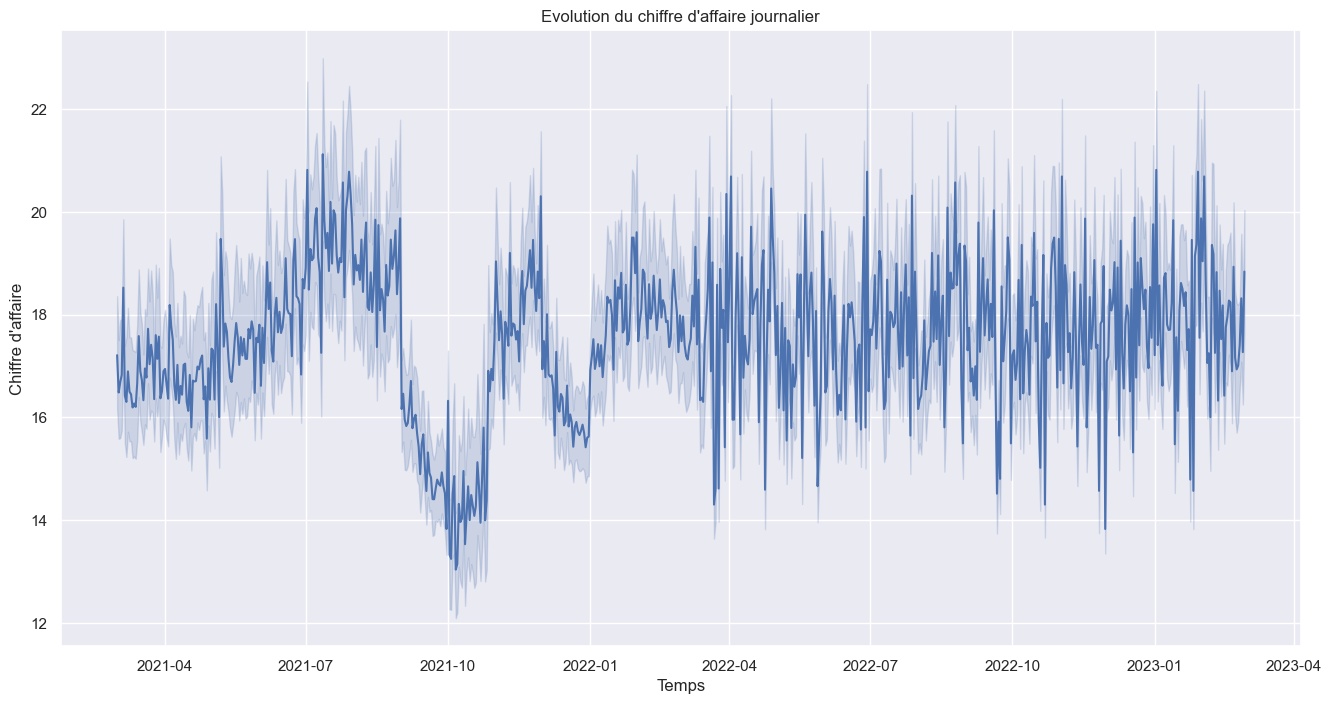

In [166]:
data["date_jour"] = data["date"].dt.date
sns.set(rc={"figure.figsize":(16,8)})
sns.lineplot(data=data, x="date_jour", y="price")
plt.title("Evolution du chiffre d'affaire journalier")
plt.xlabel("Temps")
plt.ylabel("Chiffre d'affaire")

On constate que le chiffre d'affaire a brusquement chuté après août 2021 jusqu'au mois d'octobre 2021.
La fluctuation est significative sur l'année 2021 et plus stableL'intervalle d'oscillation est moins gran
On distingue deux périodes (cf. analogie sinusoide) :
- Période 1 : 2021 avec une période de fluctuation importante
- Période 2 : après 2021, période de fluctuation significativement plus petite avec des hauts et des bas.

### *** Evolution du chiffre d'affaire journalier par catégories ***

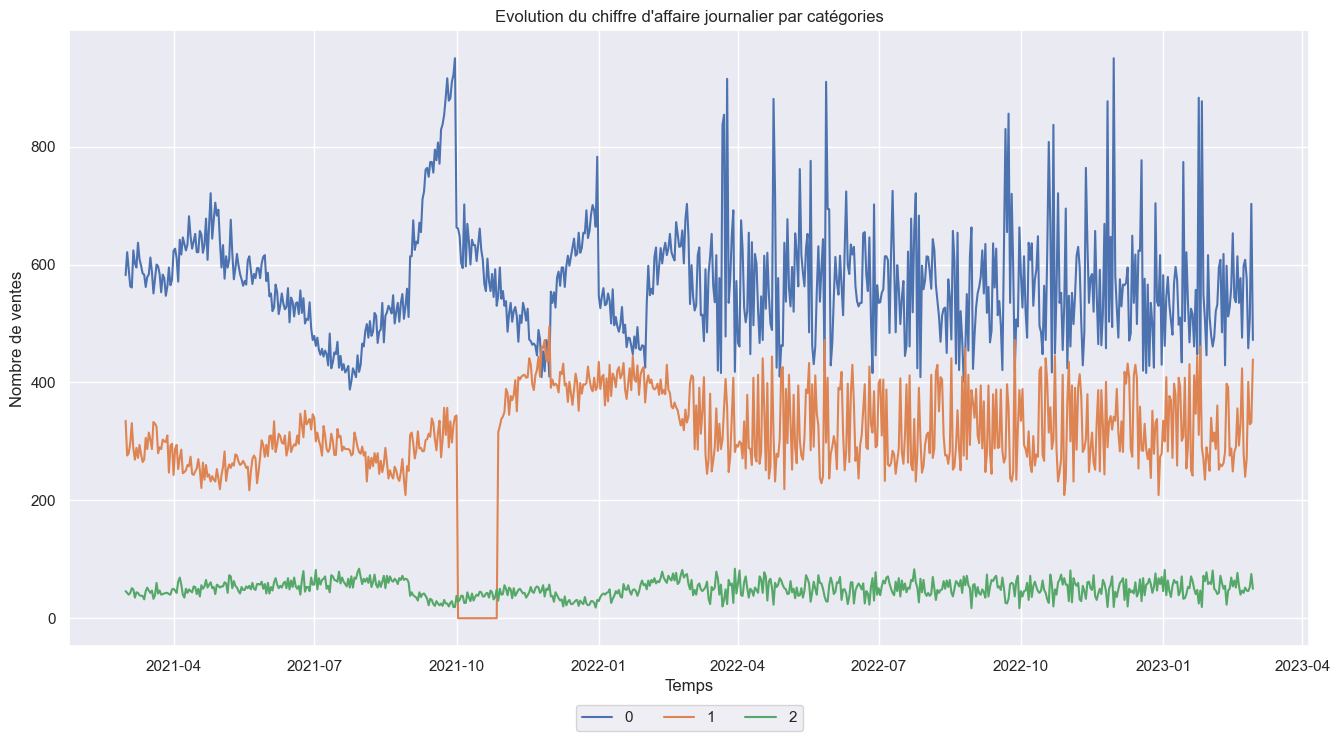

In [167]:
# Création de la colonne date_jour, sélection du format aaaa-mm-dd
data["date_jour"] = data["date"].dt.date
# Agréger les données, session_id correspond au nombre de ventes
data_vente = data.groupby(["categ", "date_jour"]).count()["session_id"].reset_index()
data_vente.head()
sns.set(rc={"figure.figsize":(16,8)})
sns.lineplot(data=data_vente, x="date_jour", y="session_id", hue="categ")
plt.title("Evolution du chiffre d'affaire journalier par catégories")
plt.xlabel("Temps")
plt.ylabel("Nombre de ventes")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)

Le fait d'afficher la série temporelle du chiffre d'affaire par catégories nous informe sur les points ci-dessous :
- catégorie 0 : pic supérieur significatif entre août et octobre 2021 traduit par un gros volume de ventes.
- catégorie 1 : aucune ventes réalisées entre octobre et novembre 2021 traduit par des ventes manquantes.
- catégorie 2 : stable

Hypothèses pouvant expliquer l'arrêt des ventes de la catégorie 1:
- bug informatique
- rupture de stock

L'intervalle de temps des pics mentionnés est approximatif, en effet, le graphique ne nous permet pas d'être plus précis. Nous allons donc chercher les périodes concernées.


### *** Analyse des intervalles de temps significatifs ***

In [168]:
# Convertir la colonne "date_jour" en date
data["date_jour"] = pd.to_datetime(data["date_jour"])
# Création d'un dataframe avec uniquement la categ 1 et après le 25 septembre 2021
df_categ1_zero = data.loc[(data["categ"] == 1) & (data["date_jour"] > "2021-09-25")]
df_categ1_zero.groupby("date_jour").agg({"categ":"count", "price":"sum", "session_id":"count"}).sort_values("date_jour").head(10)

,categ,price,session_id
date_jour,,,
2021-09-26,290,6023.22,290
2021-09-27,334,6876.56,334
2021-09-28,298,6246.91,298
2021-09-29,327,6870.45,327
2021-09-30,342,6920.45,342
2021-10-01,344,7003.79,344
2021-10-28,316,6317.99,316
2021-10-29,326,6425.18,326
2021-10-30,338,6753.69,338


On constate que nous avons un gap entre les dates du 01/10/2021 au 28/10/2021. Aucune ventes relatives à la catégorie 1 n'ont été enregistrées pour cette période (27 jours).

In [169]:
# Création d'un dataframe avec uniquement la categ 0 et avant le 5 octobre 2021
df_categ1_zero = data.loc[(data["categ"] == 0) & (data["date_jour"] < "2021-10-05")]
df_categ1_zero.groupby("date_jour").agg({"categ":"count", "price":"sum", "session_id":"count"}).sort_values("session_id", ascending=False).head(25)

,categ,price,session_id
date_jour,,,
2021-09-30,950,9973.95,950
2021-09-29,922,9645.98,922
2021-09-25,916,9831.89,916
2021-09-28,910,9665.46,910
2021-09-24,883,9371.56,883
2021-09-27,882,9412.10,882
2021-09-26,878,9367.49,878
2021-09-23,854,8882.82,854
2021-09-22,838,8845.90,838


On constate ici que le record du nombre de vente avant le mois de septembre 2021 avait été réalisé le 25/04/2021 comptabilisant 721 ventes. Ce record a été battu le 10/09/2021 avec 724 ventes et a continuer de croitre jusqu'au 30/09/2021 avec 950 ventes réalisée ce jour là!
l'augmentation du nombre de ventes s'est donc poursuivie sur 20 jours.

### *** Evolution du chiffre d'affaire mensuel ***

Text(0, 0.5, "Chiffre d'affaire")

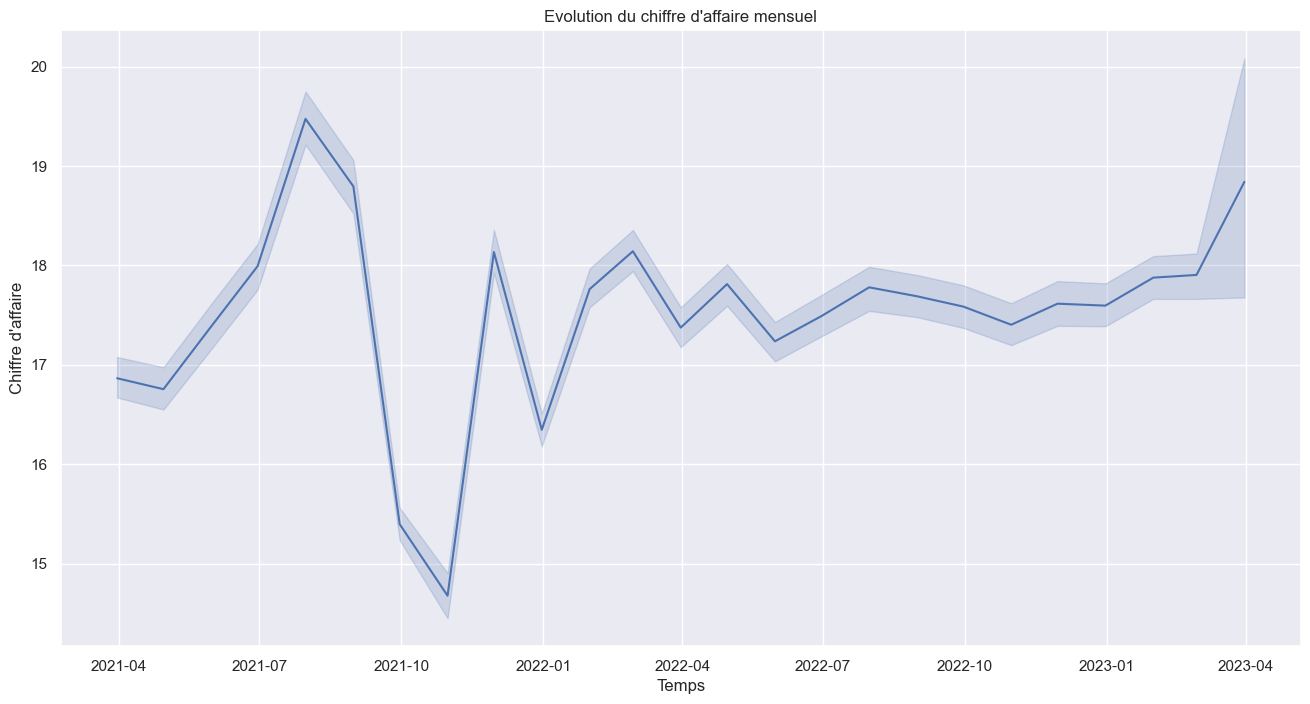

In [170]:
# date_mois correspond au dernier jour de chaque mois
data["date_mois"] = data["date_jour"] + MonthEnd(1)
sns.lineplot(data=data, x="date_mois", y="price")
plt.title("Evolution du chiffre d'affaire mensuel")
plt.xlabel("Temps")
plt.ylabel("Chiffre d'affaire")

In [171]:
# Calcul CA octobre 2021
oct_2021 = data[(data["mois"] == 10) & (data["annee"] == "2021")]
CA_oct_2021 = oct_2021["price"].sum()
# Calcul CA septembre 2021
septembre_2021 = data[(data["mois"] == 9) & (data["annee"] == "2021")]
CA_septembre_2021 = septembre_2021["price"].sum()
print("Chute significative du chiffre d'affaire au mois d'octobre 2021 atteignant {:.2f}€".format(CA_oct_2021))
print("Comparé au {:.2f}€ de chiffre d'affaire précédent!".format(CA_septembre_2021))
print("Soit une baisse de {:.0f}% !".format((CA_septembre_2021-CA_oct_2021)/CA_septembre_2021*100))

Chute significative du chiffre d'affaire au mois d'octobre 2021 atteignant 320868.67€
Comparé au 507360.56€ de chiffre d'affaire précédent!
Soit une baisse de 37% !


# I.3) Décomposition en moyenne mobile pour évaluer la tendance globale

### *** Tendance hebdomadaire du chiffre d'affaire - fréquence de 7 jours ***

Text(0, 0.5, "Chiffre d'affaire")

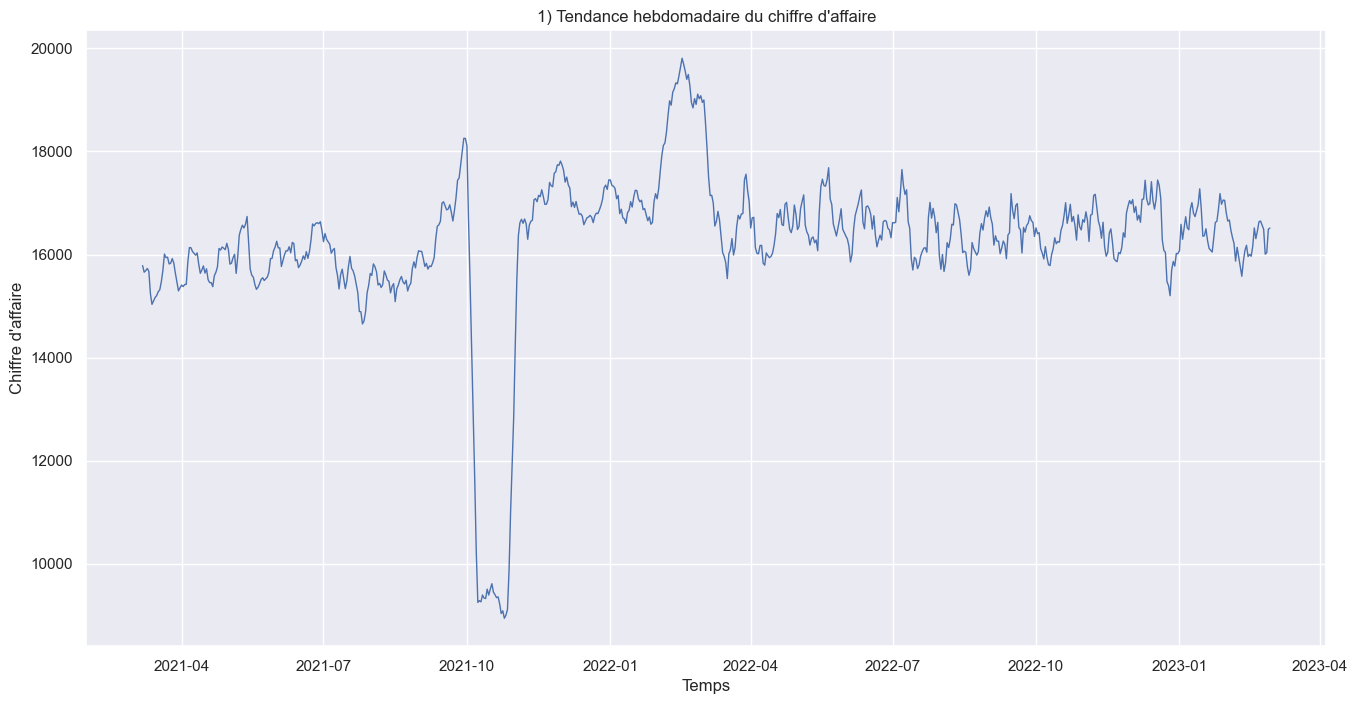

In [172]:
data_rolling_jour = data.groupby("date_jour").sum()[["price"]].reset_index()

data_rolling_jour["price_rolling_jour"] = data_rolling_jour["price"].rolling(window=7).mean()

sns.lineplot(data=data_rolling_jour, x="date_jour", y="price_rolling_jour", linewidth = 1)
plt.title("1) Tendance hebdomadaire du chiffre d'affaire")
plt.xlabel("Temps")
plt.ylabel("Chiffre d'affaire")

La décomposition en moyenne mobile a été effectué selon une fréquence hebdomadaire. Hormis les deux événements d'octobre 2021 et du début premier trimestre 2022, il y a peu de saisonalité.

# I.4) Zoom sur les références, les tops et les flops, la répartition par catégorie

### *** 1) Références - TOP 10 ***

In [173]:
df_annee.rename(columns={"price": "CA_annee"}, inplace=True)

In [174]:
df_ref = data.groupby("id_prod").agg({"categ" : "first", "price" : "sum"})
df_ref.dropna(subset="categ", inplace=True)
df_ref.rename(columns={"price":"CA_produit"}, inplace=True)
TOP = df_ref.sort_values("CA_produit", ascending=False).head(10)
TOP.head(10)

,categ,CA_produit
id_prod,,
2_159,2,94893.50
2_135,2,69334.95
2_112,2,65407.76
2_102,2,60736.78
2_209,2,56971.86
1_395,1,54356.25
1_369,1,54025.48
2_110,2,53846.25
2_39,2,53060.85


### *** 2) Références - FLOP 10 ***

In [175]:
FLOP = df_ref.sort_values("CA_produit", ascending=False).tail(10)
FLOP.sort_values("CA_produit").head(10)

,categ,CA_produit
id_prod,,
0_1539,0,0.99
0_1284,0,1.38
0_1653,0,1.98
0_541,0,1.99
0_1601,0,1.99
0_807,0,1.99
0_1728,0,2.27
0_1498,0,2.48
0_898,0,2.54


### *** Comparaison graphique entre la proportion par catégories des TOP et FLOP ***

Text(0, 0.5, '')

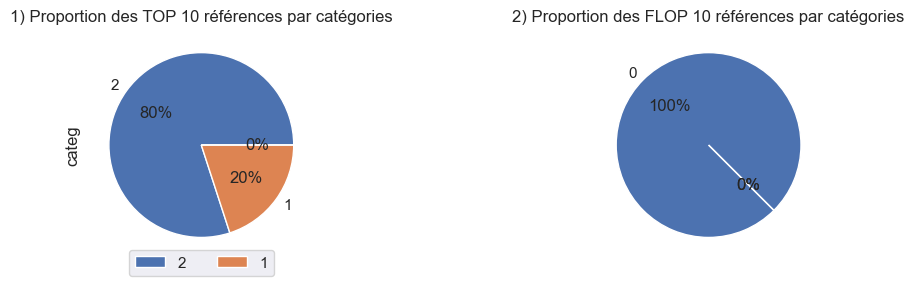

In [176]:
# Création de la grille d'affichage à 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
# 2) Pie chart (ou camembert)
TOP["categ"].value_counts().plot(kind="pie",autopct="%1.0f%%", ax=axs[0])
axs[0].set_title("1) Proportion des TOP 10 références par catégories")
axs[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=3)

FLOP["categ"].value_counts().plot(kind="pie",autopct="%1.0f%%", startangle=-45, ax=axs[1])
axs[1].set_title("2) Proportion des FLOP 10 références par catégories")
axs[1].set_ylabel("")

### *** Répartition du chiffre d'affaire par catégories ***

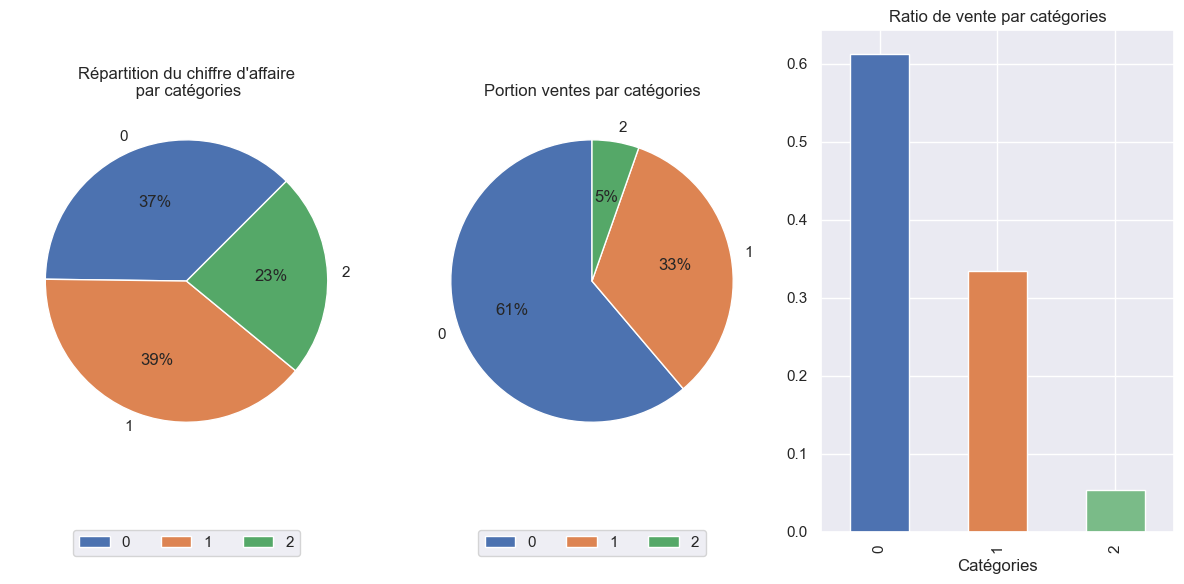

In [177]:
# Agréger les données categ
df_ca_categ = data.groupby("categ").agg({"price" : "sum"})

# Création de la grille d'affichage à 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

df_ca_categ.plot(kind="pie", y="price", autopct="%1.0f%%", startangle = 45, ax=axs[0])
axs[0].set_title("Répartition du chiffre d'affaire\n par catégories")
axs[0].set_ylabel("")
axs[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)

# Diagramme en secteurs
data["categ"].value_counts(normalize=True).plot(kind="pie", autopct="%1.0f%%", startangle=90, ax=axs[1])
axs[1].set_title("Portion ventes par catégories")
axs[1].set_ylabel("")
axs[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)

# Diagramme en tuyaux d'orgues
data["categ"].value_counts(normalize=True).plot(kind="bar", ax=axs[2], color=["#4D72B1", "#DD8452", "#7ABB88"])
axs[2].set_title("Ratio de vente par catégories")
axs[2].set_xlabel("Catégories")

# Ajuster l'espace entre les graphes
plt.tight_layout()
plt.show()

Il est intéressant de constater que la catégorie 2 représente :
   - 80% des TOP 10 références
   - 5% des produits vendus
   - 23% du chiffre d'affaire. 


Les catégories 0 et 1 sont sensiblement égales et sont donc toutes deux représentatives puisqu'elles totalisent 76% du chiffre d'affaire total.

# I.5) Quelques informations sur les profils de nos clients avec la répartition du chiffre d'affaires entre eux.

In [178]:
data.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,mois,mois_texte,annee,trim,age_client,tranche_age_client,tranche_age_client2,date_jour,date_mois
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0,f,1986.0,5,May,2022,2,37.0,35-62,35-62 ans,2022-05-20,2022-05-31
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0,f,1986.0,7,July,2021,3,37.0,35-62,35-62 ans,2021-07-20,2021-07-31
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,4.18,0,f,1986.0,8,August,2022,3,37.0,35-62,35-62 ans,2022-08-20,2022-08-31
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,8.57,0,f,1986.0,6,June,2022,2,37.0,35-62,35-62 ans,2022-06-18,2022-06-30
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,8.57,0,f,1986.0,8,August,2021,3,37.0,35-62,35-62 ans,2021-08-18,2021-08-31


In [179]:
# Tri du dataframe data en fonction des date
data.sort_values("date")
# Création du dataframe df_client
df_client = data.groupby("client_id").agg({"sex" : "first", "birth" : "first", "age_client": "first", "tranche_age_client" : "first", "tranche_age_client2":"first", "price": "sum", "session_id" : "count", "date":"first"})
# Renommer certaines colonnes
df_client.rename(columns={"price" : "Tot_achats_par_clients"}, inplace=True)
df_client.rename(columns={"date" : "date_1er_achat"}, inplace=True)
df_client.rename(columns={"session_id" : "nb_session_id"}, inplace=True)
# Tri de df_client
df_client.sort_values("Tot_achats_par_clients").head()

,sex,birth,age_client,tranche_age_client,tranche_age_client2,Tot_achats_par_clients,nb_session_id,date_1er_achat
client_id,,,,,,,,
c_8351,f,1968.0,55.0,35-62,35-62 ans,6.31,1,2021-10-26 11:46:21.315246
c_8140,m,1971.0,52.0,35-62,35-62 ans,8.30,2,2021-06-12 11:30:18.492800
c_8114,m,1962.0,61.0,35-62,35-62 ans,9.98,2,2022-08-15 08:17:35.835342
c_240,m,1998.0,25.0,20-35 ans,< 35 ans,11.06,1,2021-11-08 17:12:27.637349
c_4648,m,2004.0,19.0,< 20 ans,< 35 ans,11.20,1,2021-11-16 17:15:52.430304


### *** Répartition du chiffre d'affaires par tranche d'âge ***

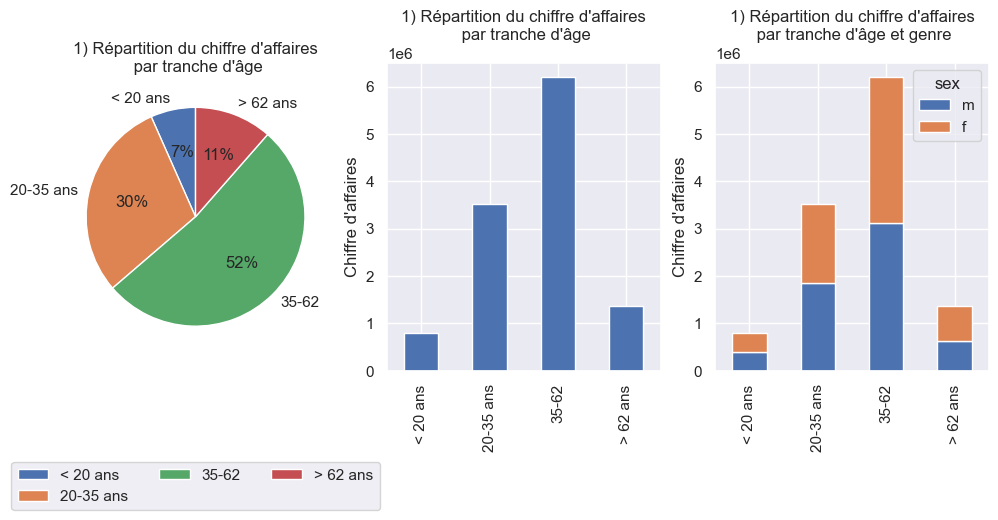

<Figure size 1600x800 with 0 Axes>

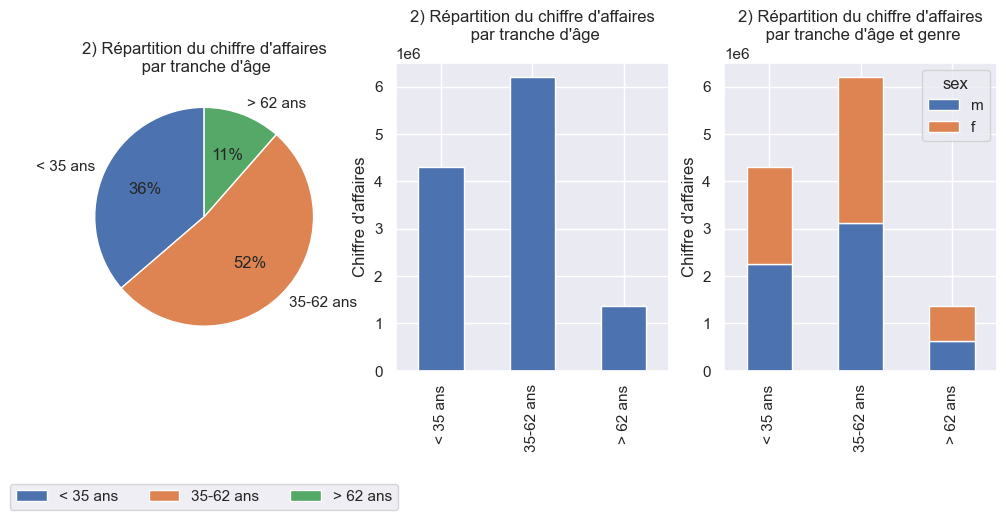

<Figure size 1600x800 with 0 Axes>

In [180]:
# Groupement par tranche d'âge et calcul de la somme du chiffre d'affaires
df_ca_age = data.groupby("tranche_age_client")["price"].sum()
# Groupement par tranche d'âge, genre et calcul de la somme du chiffre d'affaires
df_ca_age_sex = df_client.groupby(["tranche_age_client", "sex"])["Tot_achats_par_clients"].sum()

# Création de la grille d'affichage à 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Pie chart
df_ca_age.plot(kind="pie", autopct="%1.0f%%", startangle = 90, ax=axs[0])
axs[0].set_title("1) Répartition du chiffre d'affaires\n par tranche d'âge")
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.6), ncol=3)

# Histogramme sur la répartition du chiffre d'affaire
df_ca_age.plot(kind="bar", ax=axs[1])
axs[1].set_title("1) Répartition du chiffre d'affaires\n par tranche d'âge")
axs[1].set_xlabel("")
axs[1].set_ylabel("Chiffre d'affaires")

# Histogramme tenant compte du genre des clients
df_ca_age_sex.unstack().plot(kind="bar", stacked=True, ax=axs[2])
axs[2].set_title("1) Répartition du chiffre d'affaires\n par tranche d'âge et genre")
axs[2].set_xlabel("")
axs[2].set_ylabel("Chiffre d'affaires")
plt.show()

# Ajuster l'espace entre les graphes
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------------------

# Groupement par tranche d'âge et calcul de la somme du chiffre d'affaires
df_ca_age2 = data.groupby("tranche_age_client2")["price"].sum()
# Groupement par tranche d'âge, genre et calcul de la somme du chiffre d'affaires
df_ca_age_sex2 = df_client.groupby(["tranche_age_client2", "sex"])["Tot_achats_par_clients"].sum()

# Création de la grille d'affichage à 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Pie chart
df_ca_age2.plot(kind="pie", autopct="%1.0f%%", startangle = 90, ax=axs[0])
axs[0].set_title("2) Répartition du chiffre d'affaires\n par tranche d'âge")
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.6), ncol=3)

# Histogramme sur la répartition du chiffre d'affaire
df_ca_age2.plot(kind="bar", ax=axs[1])
axs[1].set_title("2) Répartition du chiffre d'affaires\n par tranche d'âge")
axs[1].set_xlabel("")
axs[1].set_ylabel("Chiffre d'affaires")

# Histogramme tenant compte du genre des clients
df_ca_age_sex2.unstack().plot(kind="bar", stacked=True, ax=axs[2])
axs[2].set_title("2) Répartition du chiffre d'affaires\n par tranche d'âge et genre")
axs[2].set_xlabel("")
axs[2].set_ylabel("Chiffre d'affaires")
plt.show()

# Ajuster l'espace entre les graphes
plt.tight_layout()
plt.show()

Les graphiques 1 et 2 traitent des tranches d'âges différents. Cependant, le graphique 2 est moins granulaire que le graphique 1. Ainsi, on constate que :
- graphique 1 : 
    - 8/10 clients ont entre 20 et 62 ans
    - moins de 1/10 client à moins de 20 ans
    - 1/10 client a plus de 62 ans
- graphique 2 :
    - 4/10 clients environ ont moins de 35 ans

Pas de différences significatives entre la proportion de femmes / hommes au regard de la répartion du chiffre d'affaire par tranche d'âge.

### *** Répartition du chiffre d'affaire total par genre (H/F) ***

Text(0.5, 1.0, "Répartition du chiffre d'affaire par genre")

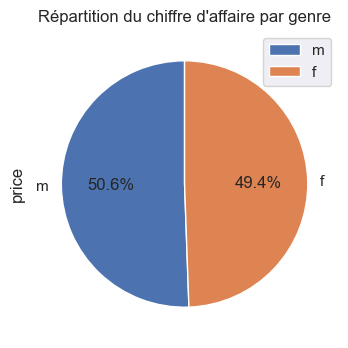

In [181]:
# Regrouper le total du chiffre d'affaire par genre
sns.set(rc={'figure.figsize':(8,4)})
df_sex = data.groupby("sex")[["price"]].sum()
# Création du pie chart
df_sex.plot(kind="pie", y="price", autopct="%1.1f%%", startangle=90)
plt.title("Répartition du chiffre d'affaire par genre")

On constate qu'il y a autant de femmes que d'hommes comme clients!

### *** Etude de la concentration - Courbe de Lorenz (chiffre d'affaire/  clients) ***

Etapes de la création de l'axe des abscisses :

- 0 représente la valeur minimale de l'axe, qui est égale à 0.
- 1 représente la valeur maximale de l'axe, qui est égale à 1 plus un intervalle correspondant à la fraction d'un client (1/n).
- n+1 représente le nombre total de points sur l'axe, qui est égal au nombre de clients (n) + 1 point supplémentaire pour terminer la courbe de Lorenz à 100 %.

Text(0, 0.5, "Répartition du chiffre d'affaire (%)")

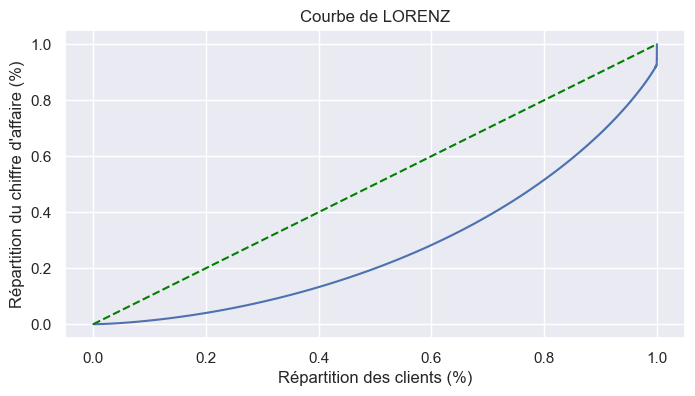

In [182]:
panier_client = df_client["Tot_achats_par_clients"].values
n = len(panier_client)
# Trie par ordre croissant des montants, calcul de leurs sommes cumulées, on divise la somme totale des achats
# On obtient les ratios de Lorenz.
lorenz = np.cumsum(np.sort(panier_client)) / panier_client.sum()
# Ajout d'un 0 en début de la liste
lorenz = np.append([0],lorenz) 
# Axe des abscisses allant de 0 à 1
xaxis = np.linspace(0, 1, n+1) 
# Courbe de Lorenz
plt.plot(xaxis, lorenz, drawstyle="steps-post")
# Bissectrice (égalité parfaite)
plt.plot([0,1],[0,1],color="green", linestyle="--")
plt.title("Courbe de LORENZ")
plt.xlabel("Répartition des clients (%)")
plt.ylabel("Répartition du chiffre d'affaire (%)")

On constate que : 
- 80% des clients représente 50% du chiffre d'affaire total
- 20% des clients réalisent 50% du chiffre d'affaire total.
- l'aplatissement de la courbe de Lorenz à son extrémité droite représente une minorité de clients qui ont généré un chiffre d'affaire significativement supérieur au reste de la population.

##
# II) Une analyse plus ciblée sur les clients - demandé par Julie

## II.1) Lien entre le genre d’un client et les catégories des livres achetés

Avant de commencer l'analyse, il y a une question à ce poser :
- Quel type de variable sont présentes ?

Ici, le genre d'un client et les catégories de livres sont toutes deux des variables **Qualitatives**.

### *** Tableau de contingence - [Genre / Categ] ***
Chaque case du tableau de contingence compte un nombre d'individus. Ce comptage se fait grâce à la fonction  len


<AxesSubplot: xlabel='categ', ylabel='sex'>

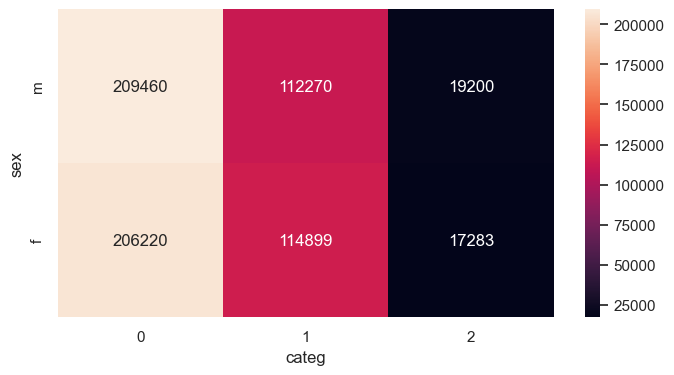

In [183]:
X = "sex"
Y = "categ"
tab_cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=False,margins_name="Total")
sns.heatmap(data=tab_cont, annot=True, fmt="g")

In [184]:
X = "sex"
Y = "categ"
tab_cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
tab_cont

categ,0,1,2,Total
sex,,,,
m,209460,112270,19200,340930
f,206220,114899,17283,338402
Total,415680,227169,36483,679332


### *** Test statistique d'indépédence du khi-2 (X²) ***

- H0 = les variables "sex" et "categ" sont **indépendantes** si p-value **>** 0.05
- H1 = les variables "sex" et "categ" sont **dépendantes** si p-value **<** 0.05

1) observees = effectifs observés pour chaque combinaison de modalités de sex et categ 
2) total_observees = les totaux observés pour chaque modalité de sex (X)
3) total_attendu = les totaux attendus pour chaque modalité de categ (Y)

In [185]:
# Sélection de toutes les valeurs sauf les totaux marginaux
observees = tab_cont.iloc[:-1, :-1].values
# Sélection de toutes les lignes sauf la dernière
total_observees = tab_cont.iloc[:-1, -1].values.reshape(-1, 1)
# Sélection de toutes les colonnes sauf la dernière
total_attendu = tab_cont.iloc[-1, :-1].values.reshape(1, -1)

# Calcul du test du khi-2
chi2, pval, dof, attendu = chi2_contingency(observees, correction=False)

# Affichage des résultats
print("Valeur du test : {:.5f}".format(chi2))
print("Valeur p : ", pval)
print("Degrés de liberté : ", dof)
print("Tableau des valeurs attendues : ")
print(attendu)

Valeur du test : 147.00254
Valeur p :  1.1989607410166063e-32
Degrés de liberté :  2
Tableau des valeurs attendues : 
[[208613.43555139 114007.18230556  18309.38214305]
 [207066.56444861 113161.81769444  18173.61785695]]


Vérifions le calcul du dof (degrees of freedom / degré de liberté) qui se calcule comme ci-dessous :
-    dof = (nb_lignes - 1) x (nb_colonnes -1)  = (2-1) x (3-1)    = 2

**<font color="green">Hypothèse :</font>** H0 rejetée car la Valeur p < 0.05 :
- 1.1989607410166063e-32 **<** 0.05.
- Nous avons au regard du test statistique du khi-2 une **<font color='red'>dépendance</font>** entre le genre des clients et les catégories achetées.

## II.2) Lien entre l’âge des clients et le montant total des achats

Text(0.5, 0, 'Age')

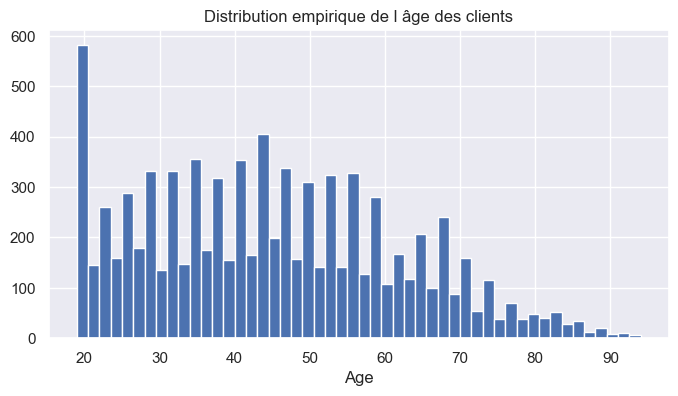

In [186]:
# Histogramme
sns.set(rc={"figure.figsize":(8,4)})
df_client["age_client"].hist(bins=50)
plt.title("Distribution empirique de l âge des clients")
plt.xlabel("Age")

In [187]:
# Test de Shapiro-Wilk
stat, p = shapiro(df_client["age_client"])
print("stat = %.3f, p-value = %.50f" % (stat, p))
if p > 0.05:
    print("La distribution de la variable âge est normale")
else:
    print("La distribution de la variable âge n'est pas normale")

stat = 0.970, p-value = 0.00000000000000000000000000000000000000461823973070
La distribution de la variable âge n'est pas normale


### **<font color="green">A) </font>** L'âge des clients et le montant total des achats sont toutes deux des variables **Quantitatives**.

In [188]:
# Agréger les données en fonction de l'âge et du montant total dépensé par client
df_client2 = df_client.groupby("age_client").agg({"Tot_achats_par_clients":"sum"}).reset_index()
df_client2.head()

,age_client,Tot_achats_par_clients
0,19.0,609013.69
1,20.0,178195.78
2,21.0,184207.32
3,22.0,178497.70
4,23.0,165027.96


### *** Distribution empirique des variables ***

Text(0, 0.5, 'Densité')

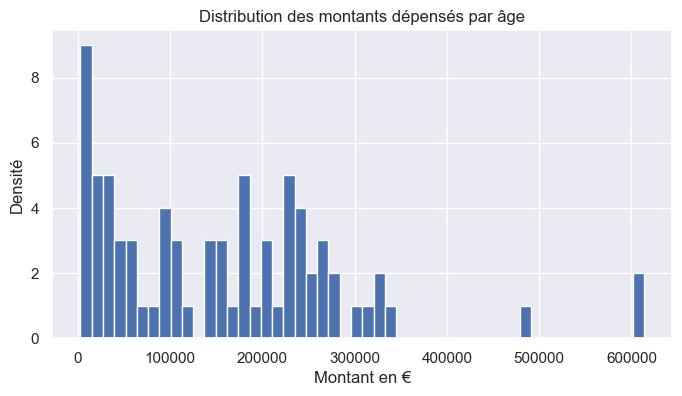

In [189]:
# Histogramme
sns.set(rc={"figure.figsize":(8,4)})
df_client2["Tot_achats_par_clients"].hist(bins=50)
plt.title("Distribution des montants dépensés par âge")
plt.xlabel("Montant en €")
plt.ylabel("Densité")

In [190]:
# Test de Shapiro-Wilk
stat, p = shapiro(df_client2["Tot_achats_par_clients"])
print("stat = %.3f, p-value = %.50f" % (stat, p))
if p > 0.05:
    print("La distribution du montant des achats est normale")
else:
    print("La distribution du montant des achats n'est pas normale")

stat = 0.888, p-value = 0.00000635473043075762689113616943359375000000000000
La distribution du montant des achats n'est pas normale


### *** Diagramme de dispersion ***

<AxesSubplot: xlabel='age_client', ylabel='Tot_achats_par_clients'>

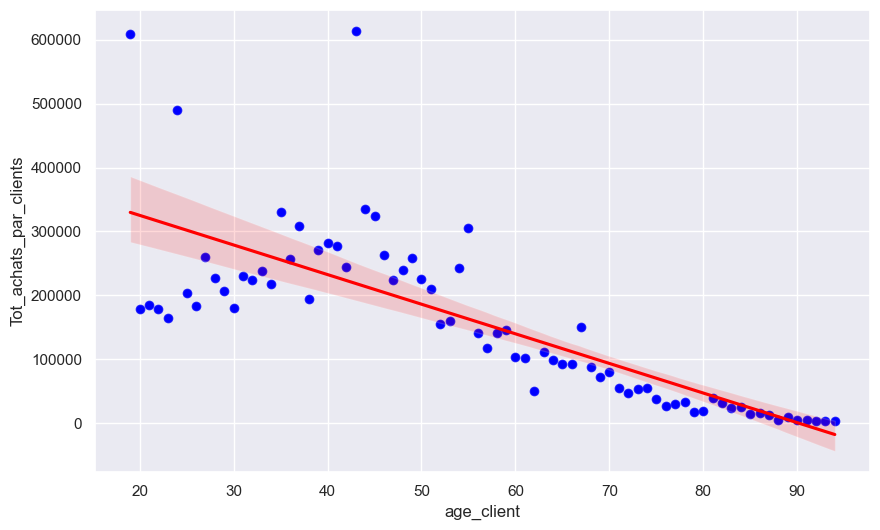

In [191]:
# Création du diagramme de dispersion
sns.set(rc={"figure.figsize":(10,6)})
sns.scatterplot(x="age_client", y="Tot_achats_par_clients", data=df_client2,  color="blue")
# scatter_kws est utilisé pour passer des arguments supplémentaires
sns.regplot(x="age_client", y="Tot_achats_par_clients", data=df_client2, color="red", scatter_kws={"color": "blue"})

Le diagramme de dispersion ci-dessus affiche une **<font color='red'>une corrélation négative</font>**  mais avant de l'affirmer, nous allons calculer le coefficient de corrélation **r** plus connu sous le nom de coefficient de Pearson qui est utile pour analyser des relations **linéaires**.

In [192]:
print("Coefficient de corrélation de Pearson = {:.6f}".format(st.pearsonr(df_client2["age_client"],df_client2["Tot_achats_par_clients"])[0]))

Coefficient de corrélation de Pearson = -0.778862


Nous obtenons un coefficient de **<font color='green'>Pearson</font>**  négatif ce qui vient confirmer le diagramme de dispersion. La valeur obtenue étant supérieure à 0.5, et proche de 1, nous **pourrions** conclure sur la base de cette analyse qu'il y a une **<font color='red'>corrélation</font>**  entre l'âge des clients et le montant total des achats.

Cependant, le coefficient de Pearson n'est applicable que pour mesurer la relation entre deux variables X et Y ayant une distribution de type gaussien et ne comportant pas d'outliers. Or, nous savons que la variable "Tot_achats par clients" ne suit pas une loi Normale et nous avons des outliers (3)... par conséquent l'emploi de ce coefficient peut aboutir à des conclusions erronées sur la présence ou l'absence d'une relation.

Nous allons donc calculer le coefficient de Spearman qui évalue la corrélation entre deux variables continues (quantitatives). 
- méthode de mesure non paramétrique, ce qui signifie qu'elle ne suppose pas que les données suivent une distribution normale ou tout autre type de distribution particulier (ce qui nous convient ici!).  
- Elle est souvent utilisée dans les cas où les données ne suivent pas une distribution normale ou dans lesquels les valeurs aberrantes (**outliers**) peuvent fausser les résultats.

Par conséquent, **<font color='green'>le test de Spearman est plus robuste</font>**  que le test de Pearson.

In [193]:
correl, p_val = stats.spearmanr(df_client2["age_client"], df_client2["Tot_achats_par_clients"])
print("Coefficient de corrélation de Spearman :", correl)
print("p-value :", p_val)

Coefficient de corrélation de Spearman : -0.8576076555023923
p-value : 4.57972879340901e-23


Conclusion : 
- on obtient une p-value inférieure à 0.05 et un coefficient > 85%
- Le test de **<font color='green'>Spearman</font>** confirme le test de Pearson en indiquant qu'il y a bien une **<font color='red'>corrélation</font>**  entre l'âge des clients et le montant total des achats. 
- Il semblerait que plus les clients sont âgés, et moins ils dépensent !


## II.3) Lien entre l’âge des clients et la fréquence d’achat

### *** Calcul de la fréquence d'achat *** 

In [194]:
display(data["date"].min())
data["date"].max()

Timestamp('2021-03-01 00:01:07.843138')

Timestamp('2023-02-28 23:58:30.792755')

In [195]:
# Date référence
ref_date = datetime(2023, 2, 28)
ref_date2 = datetime(2021, 3, 1)
# Calcul de la période de temps représenté par notre étude
periode_mois = (ref_date - ref_date2)
# Calcul de la fréquence d'achat ramené au mois
df_client["frequence_achat"] = df_client["nb_session_id"] / (periode_mois.days/30)
display(periode_mois.days/30)
df_client.sort_values("frequence_achat", ascending=False)[["nb_session_id", "frequence_achat"]].head()

24.3

,nb_session_id,frequence_achat
client_id,,
c_1609,25488,1048.888889
c_6714,9187,378.065844
c_3454,6773,278.724280
c_4958,5195,213.786008
c_3263,403,16.584362


In [196]:
# Agréger les données en fonction de l'âge et la fréquence d'achat
df_client3 = df_client.groupby("age_client").agg({"frequence_achat":"mean"}).reset_index()
df_client3.sort_values("frequence_achat", ascending=False, inplace=True)
# Afficher le dataframe
df_client3.rename(columns={"frequence_achat":"frequence_achat_moy"},inplace=True)
display(df_client3.head())
# Afficher le même dataframe sans outliers
df_client3bis = df_client3.copy()
# Suppression de l'âge 43
df_client3bis = df_client3bis[~df_client3bis["age_client"].isin([43])]
print("\n *** Dataframe sans outliers ***")
df_client3bis.rename(columns={"frequence_achat_moy":"frequence_achat_moy_sans_outliers"}, inplace=True)
df_client3bis.head()

,age_client,frequence_achat_moy
24,43.0,10.215457
20,39.0,5.431833
21,40.0,5.428796
19,38.0,5.238146
26,45.0,5.103087



 *** Dataframe sans outliers ***


,age_client,frequence_achat_moy_sans_outliers
20,39.0,5.431833
21,40.0,5.428796
19,38.0,5.238146
26,45.0,5.103087
30,49.0,5.003601


### *** Distribution de la fréquence d'achat ***

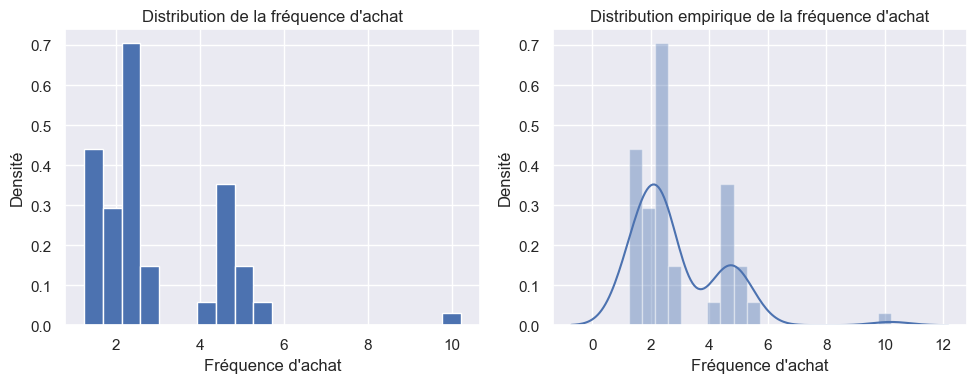

In [197]:
# Création de la grille d'affichage à 1 ligne et 2 colonnes
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Histogramme
df_client3["frequence_achat_moy"].hist(density=True, bins=20, ax=axs[0])
axs[0].set_title("Distribution de la fréquence d'achat")
axs[0].set_xlabel("Fréquence d'achat")
axs[0].set_ylabel("Densité")

# Courbe de densité
sns.distplot(df_client3["frequence_achat_moy"], bins=20, ax=axs[1])
axs[1].set_title("Distribution empirique de la fréquence d'achat")
axs[1].set_xlabel("Fréquence d'achat")
axs[1].set_ylabel("Densité")

# Ajuster l'espace entre les graphes
plt.tight_layout()
plt.show()

In [198]:
# Test de Shapiro-Wilk
stat, p = shapiro(df_client3["frequence_achat_moy"])
print("stat = %.3f, p-value = %.10f" % (stat, p))
if p > 0.05:
    print("La distribution de la fréquence des achats est normale")
else:
    print("La distribution de la fréquence des achats n'est pas normale")

stat = 0.799, p-value = 0.0000000084
La distribution de la fréquence des achats n'est pas normale


### *** Diagramme de dispersion ***

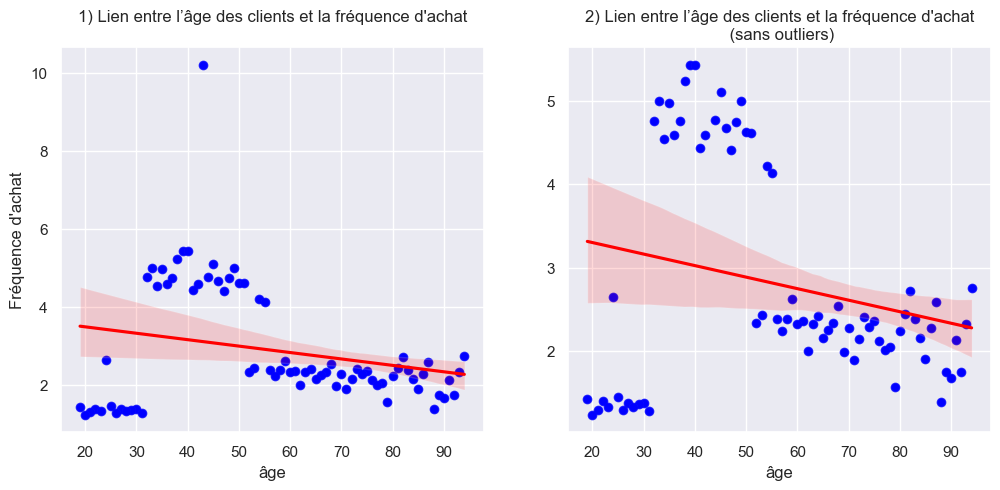

1) Coefficient de Pearson = -0.234410
2) Coefficient de Pearson sans outlier = -0.234319
3) Coefficient de Spearman = -0.075680
4) Coefficient de Spearman sans outlier = -0.065491


In [199]:
# Création de la grille d'affichage à 1 ligne et 2 colonnes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Diagramme de dispersion N°1
sns.scatterplot(x="age_client", y="frequence_achat_moy", data=df_client3,  color="blue", ax=axs[0])
# scatter_kws est utilisé pour passer des arguments supplémentaires
sns.regplot(x="age_client", y="frequence_achat_moy", data=df_client3, color='red', scatter_kws={"color": "blue"}, ax=axs[0])
axs[0].set_title("1) Lien entre l’âge des clients et la fréquence d'achat\n")
axs[0].set_xlabel("âge")
axs[0].set_ylabel("Fréquence d'achat")

# Diagramme de dispersion N°2
sns.scatterplot(x="age_client", y="frequence_achat_moy_sans_outliers", data=df_client3bis,  color="blue", ax=axs[1])
# scatter_kws est utilisé pour passer des arguments supplémentaires
sns.regplot(x="age_client", y="frequence_achat_moy_sans_outliers", data=df_client3bis, color='red', scatter_kws={"color": "blue"}, ax=axs[1])
axs[1].set_title("2) Lien entre l’âge des clients et la fréquence d'achat\n (sans outliers)")
axs[1].set_xlabel("âge")
axs[1].set_ylabel("")
plt.show()
# Calcul du coefficient de Pearson
print("1) Coefficient de Pearson = {:.6f}".format(st.pearsonr(df_client3["age_client"],df_client3["frequence_achat_moy"])[0]))
print("2) Coefficient de Pearson sans outlier = {:.6f}".format(st.pearsonr(df_client3bis["age_client"],df_client3bis["frequence_achat_moy_sans_outliers"])[0]))
print("3) Coefficient de Spearman = {:.6f}".format(stats.spearmanr(df_client3["age_client"], df_client3["frequence_achat_moy"])[0]))
print("4) Coefficient de Spearman sans outlier = {:.6f}".format(stats.spearmanr(df_client3bis["age_client"], df_client3bis["frequence_achat_moy_sans_outliers"])[0]))

Il y a 1 outlier ou valeur atypique bien visible sur le diagramme de dispersion de gauche (1). En isolant celui-ci, on obitent le diagramme de droite (2) qui vient confirmer de façon plus franche **<font color="green">une faible corrélation négative</font>**.

## II.4) Lien entre l’âge des clients et la taille du panier moyen

In [200]:
# Agréger les données en fonction de l'âge et du montant total dépensé par client
df_client4 = data.groupby("age_client").agg({"id_prod":"count"}).rename(columns={"id_prod":"nombre_produits"}).reset_index()\
.sort_values("nombre_produits", ascending=False)
# Afficher le dataframe
display(df_client4.head())
# Afficher le même dataframe sans outliers
df_client5 = df_client4.copy()
# Suppression des outliers 43 ans
df_client5 = df_client5[~df_client5["age_client"].isin([43])]
df_client5.head()

,age_client,nombre_produits
24,43.0,47413
16,35.0,25005
25,44.0,24893
26,45.0,24677
18,37.0,23475


,age_client,nombre_produits
16,35.0,25005
25,44.0,24893
26,45.0,24677
18,37.0,23475
21,40.0,21371


### *** Distribution du Panier moyen ***

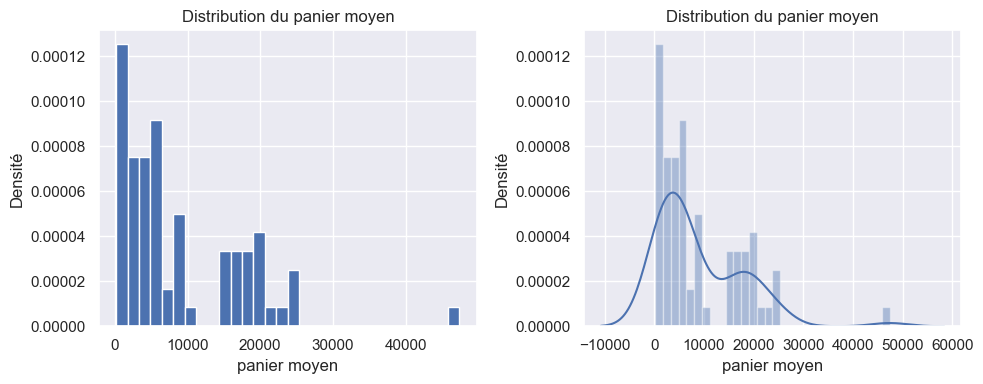

In [201]:
# Création de la grille d'affichage à 1 ligne et 2 colonnes
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Histogramme
df_client4["nombre_produits"].hist(density=True, bins=30, ax=axs[0])
axs[0].set_title("Distribution du panier moyen")
axs[0].set_xlabel("panier moyen")
axs[0].set_ylabel("Densité")

# Courbe de densité
sns.distplot(df_client4["nombre_produits"], ax=axs[1], bins=30)
axs[1].set_title("Distribution du panier moyen")
axs[1].set_xlabel("panier moyen")
axs[1].set_ylabel("Densité")

# Ajuster l'espace entre les graphes
plt.tight_layout()
plt.show()

In [202]:
# Test de Shapiro-Wilk
stat, p = shapiro(df_client4["nombre_produits"])
print("stat = %.5f, p-value = %.10f" % (stat, p))
if p > 0.05:
    print("La distribution est normale")
else:
    print("La distribution n'est pas normale")

stat = 0.83384, p-value = 0.0000000865
La distribution n'est pas normale


### *** Diagramme de dispersion ***

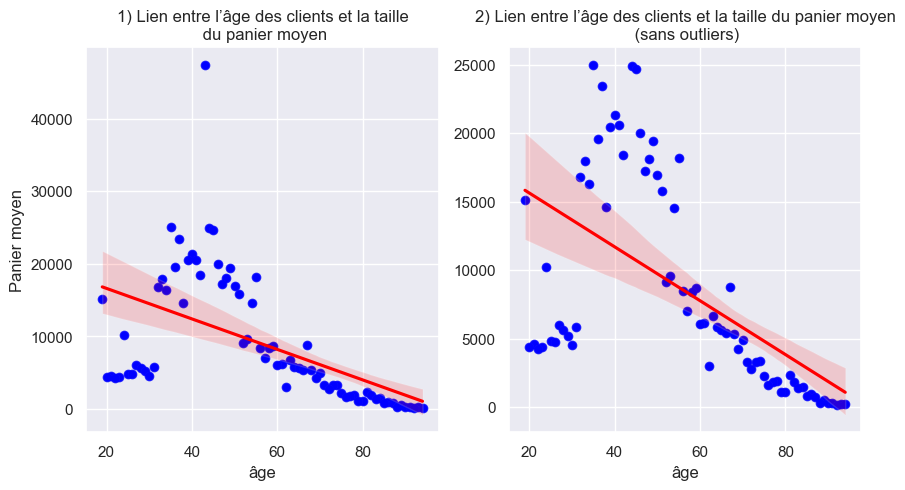

1) Coefficient de Pearson = -0.533705
2) Coefficient de Pearson sans outliers = -0.581224
3) Coefficient de Spearman = -0.684621
4) Coefficient de Spearman sans outliers = -0.689644


In [203]:
# Création de la grille d'affichage à 1 ligne et 2 colonnes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x="age_client", y="nombre_produits", data=df_client4,  color="blue", ax=axs[0])
# Droite de régression, scatter_kws est utilisé pour passer des arguments supplémentaires
sns.regplot(x="age_client", y="nombre_produits", data=df_client4, color="red", scatter_kws={"color": "blue"}, ax=axs[0])
axs[0].set_title("1) Lien entre l’âge des clients et la taille\n du panier moyen")
axs[0].set_xlabel("âge")
axs[0].set_ylabel("Panier moyen")

# Création du diagramme de dispersion
sns.scatterplot(x="age_client", y="nombre_produits", data=df_client5,  color="blue", ax=axs[1])
# scatter_kws est utilisé pour passer des arguments supplémentaires
sns.regplot(x="age_client", y="nombre_produits", data=df_client5, color="red", scatter_kws={"color": "blue"}, ax=axs[1])
axs[1].set_title("2) Lien entre l’âge des clients et la taille du panier moyen\n (sans outliers)")
axs[1].set_xlabel("âge")
axs[1].set_ylabel("")
plt.show()

# Calcul du coefficient de Pearson
print("1) Coefficient de Pearson = {:.6f}".format(st.pearsonr(df_client4["age_client"],df_client4["nombre_produits"])[0]))
print("2) Coefficient de Pearson sans outliers = {:.6f}".format(st.pearsonr(df_client5["age_client"],df_client5["nombre_produits"])[0]))
print("3) Coefficient de Spearman = {:.6f}".format(stats.spearmanr(df_client4["age_client"], df_client4["nombre_produits"])[0]))
print("4) Coefficient de Spearman sans outliers = {:.6f}".format(stats.spearmanr(df_client5["age_client"], df_client5["nombre_produits"])[0]))

Après suppression des 43 ans bien visible sur le diagramme de dispersion (1), on constate que le coefficient de Pearson sans outliers vient confirmer le diagramme de dispersion ajusté (2) qui affiche  **<font color='red'>une corrélation négative</font>** . Le coefficient de **<font color='green'>Spearman</font>**  vient étayer cette conclusion.
- La valeur obtenue est proche de 1... autrement dit, nous pouvons conclure que l'âge des clients et le montant du panier moyen ont un lien de **<font color='red'>dépendance</font>**.
     - le nombre de produits moyen acheté diminue avec l'âge (en globalité).

## II.5) Lien entre l’âge des clients et les catégories achetées

### *** Graphiques de densité (Kernel density plot) ***

Text(0, 0.5, 'Densité')

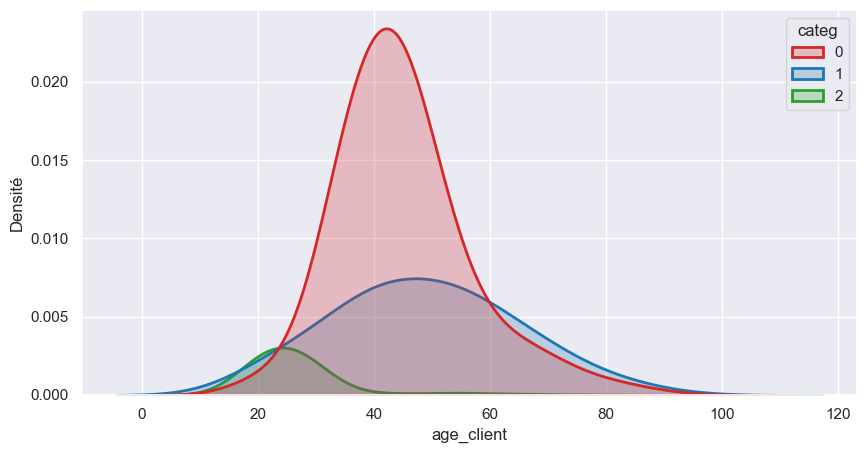

In [204]:
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(10,5)})
custom_palette = ["#d62728", "#1f77b4", "#2ca02c"]
sns.kdeplot(x="age_client", hue="categ", data=data,  color="blue", palette=custom_palette, linewidth=2, shade=True, bw=0.5)
plt.ylabel("Densité")

### *** Histogramme ***

In [205]:
print("Dataframe A - 4 tranches d'âge")
tranche_age_client_categ = data.groupby(["tranche_age_client", "categ"]).agg({"tranche_age_client":"first", "categ":"count"})
display(tranche_age_client_categ.head())
print("")
print("Dataframe B - 3 tranches d'âge")
tranche_age_client2_categ = data.groupby(["tranche_age_client2", "categ"]).agg({"tranche_age_client2":"first", "categ":"count"})
tranche_age_client2_categ.head()

Dataframe A - 4 tranches d'âge


tranche_age_client  categ
tranche_age_client categ                          
< 20 ans           0               < 20 ans   4327
                   1               < 20 ans   7397
                   2               < 20 ans   7796
20-35 ans          0              20-35 ans  70618
                   1              20-35 ans  40085


Dataframe B - 3 tranches d'âge


tranche_age_client2   categ
tranche_age_client2 categ                            
< 35 ans            0                < 35 ans   74945
                    1                < 35 ans   47482
                    2                < 35 ans   33504
35-62 ans           0               35-62 ans  305382
                    1               35-62 ans  134743

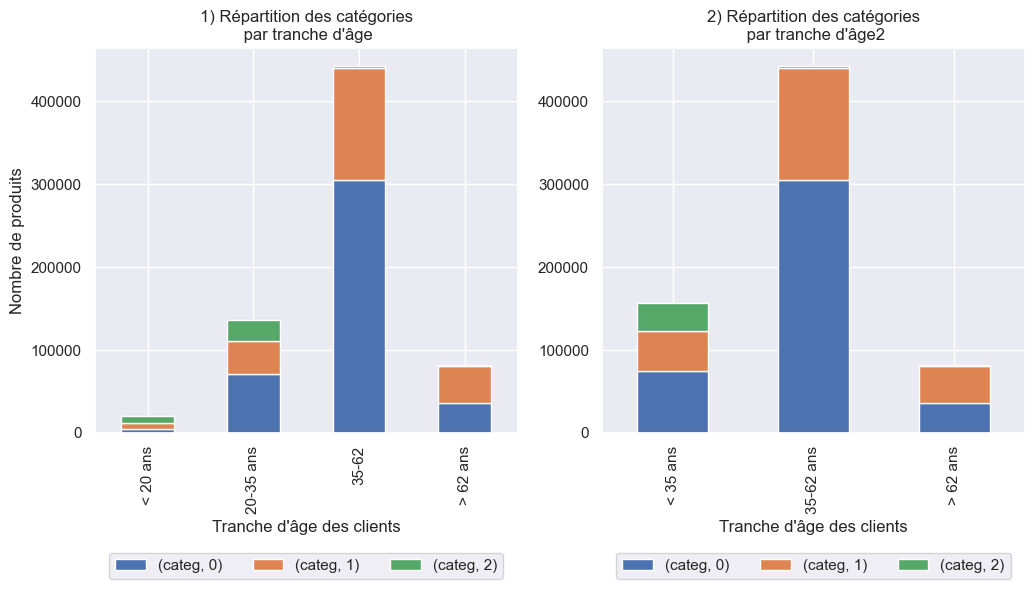

In [206]:
# Création de la grille d'affichage à 1 ligne et 2 colonnes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogramme 1
tranche_age_client_categ.unstack().plot(kind="bar", stacked=True, ax=axs[0])
axs[0].set_title("1) Répartition des catégories\n par tranche d'âge")
axs[0].set_xlabel("Tranche d'âge des clients")
axs[0].set_ylabel("Nombre de produits")
axs[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=3)

# Histogramme 2
tranche_age_client2_categ.unstack().plot(kind="bar", stacked=True, ax=axs[1])
axs[1].set_title("2) Répartition des catégories\n par tranche d'âge2")
axs[1].set_xlabel("Tranche d'âge des clients")
axs[1].set_ylabel("")
axs[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=3)

### *** Rapport de corrélation noté η² ***

In [207]:
grouped_data_df = data.groupby(["age_client", "categ"]).agg({"age_client":"first", "categ":"count"})
grouped_data_df.head()

age_client  categ
age_client categ                   
19.0       0            19.0   3418
           1            19.0   5719
           2            19.0   6012
20.0       0            20.0    909
           1            20.0   1678

In [208]:
X = "categ"      # qualitative
Y = "age_client" # quantitative

aov = pg.anova(data=grouped_data_df, dv=Y, between=X, detailed=True)
# η² = SCE / (SCE + SCR) = SCE / SCT
# SCE (somme des carrés expliquée) traduit la variation interclasse --> SS[0]
# SCR (somme des carrés résiduelle) traduit la variation inexpliquée par le modèle --> SS[1]
eta_squared = aov.SS[0] / (aov.SS[0] + aov.SS[1])

print("η² = {:.8f}".format(eta_squared))

η² = 0.92631579


La valeur de eta carré nous donne une idée de la force de l'association :
- si η² est proche de 0, cela indique une faible association
- si η² est proche de 1, cela indique une forte association.


Le rapport de corrélation noté η² permet d'évaluer numériquement la corrélation.
Ici, nous avons η² proche de 1, nous avons donc une  **<font color='red'>corrélation</font>**  entre les variables âge et catégories.